# This is for analyzing the enrichment of ISREs that are abolished or created by or flanked by HGMD variants

In [1]:
whichDataSet = "HGMD"

In [2]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re2
import seaborn as sns

In [11]:
# Seperate ISRE motifs between ISEs and ISSs
ISE_motifs = pd.read_csv("../data/ISE_ZWpaper_OverrepresentedHexamers.tsv",header=None)
ISS_motifs = pd.read_csv("../data/ISS_ZWpaper_OverrepresentedHexamers.tsv",header=None)

In [4]:
# Reads in ISRE motifs found in introns file
introns_ISREs_singleLocation = pd.read_csv("../processed_data/Introns_Intersect_ISREs_singleISRElocation.txt",header=None,sep="\t")
print introns_ISREs_singleLocation.shape
introns_ISREs_singleLocation.head()

(23964596, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925804,925810,GTGTGG,+
1,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925820,925826,GTATTT,+
2,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925805,925811,TGTGGG,+
3,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925842,925848,AGGGGG,+
4,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925839,925845,GGGAGG,+


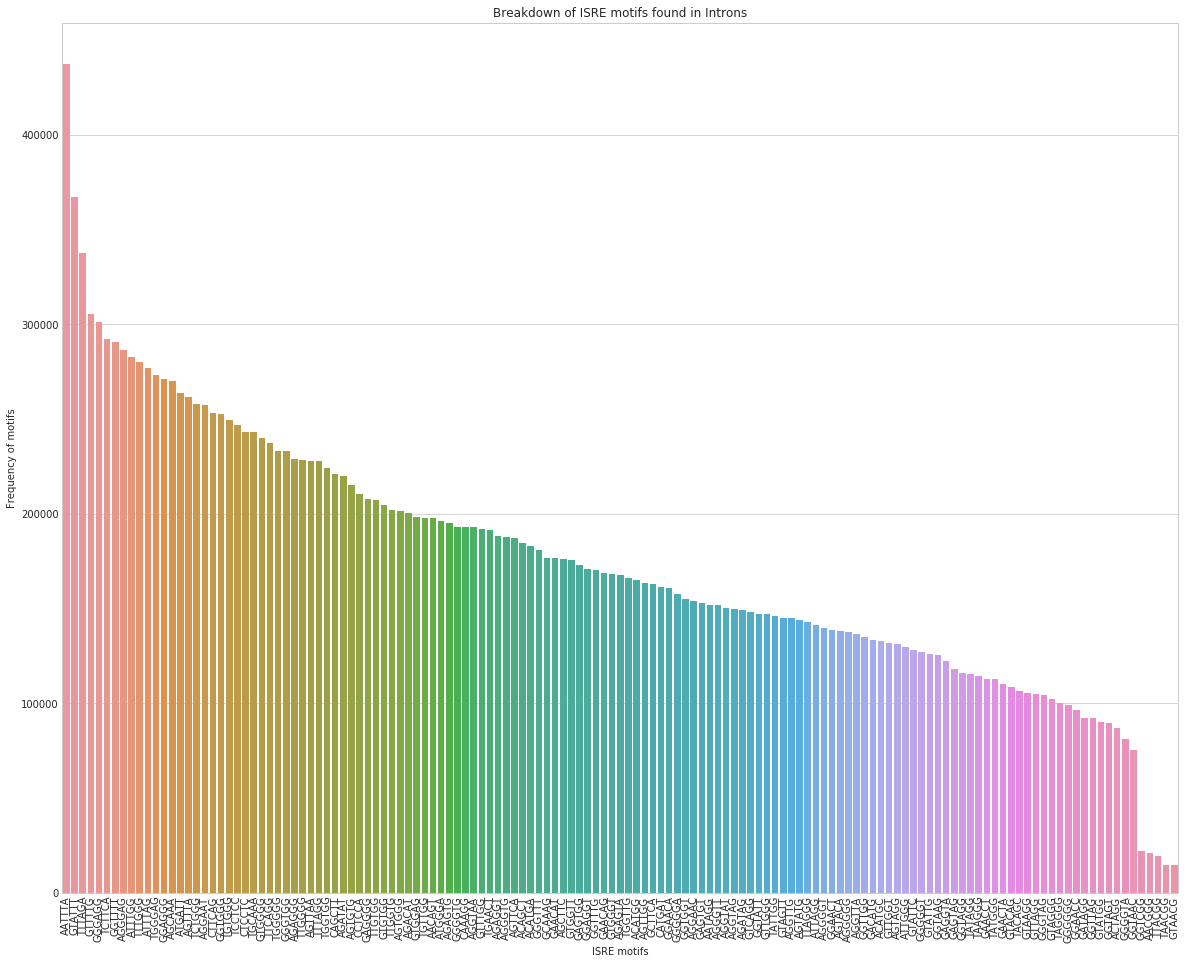

In [5]:
# Look for overrepresented ISREs in introns
ISREs_inIntron_Count = introns_ISREs_singleLocation[9].value_counts()
ISREs_inIntron_Count_df = pd.DataFrame({"Numbers":ISREs_inIntron_Count.values,"ISREmotifs":ISREs_inIntron_Count.index.values},columns=["ISREmotifs","Numbers"])
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_inIntron_Count_df)
plt.xlabel("ISRE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs found in Introns")
plt.show()

In [6]:
# Lets sort the ISRE motif counts by motif
ISREs_inIntron_Count_df_sorted = ISREs_inIntron_Count_df.sort_values(["ISREmotifs"])
print ISREs_inIntron_Count_df_sorted.shape
ISREs_inIntron_Count_df_sorted.head()

(137, 2)


,ISREmotifs,Numbers
45,AACAGT,197871
133,AACGGG,21150
79,AATAGG,152121
0,AATTTA,437252
56,ACAGCT,184786


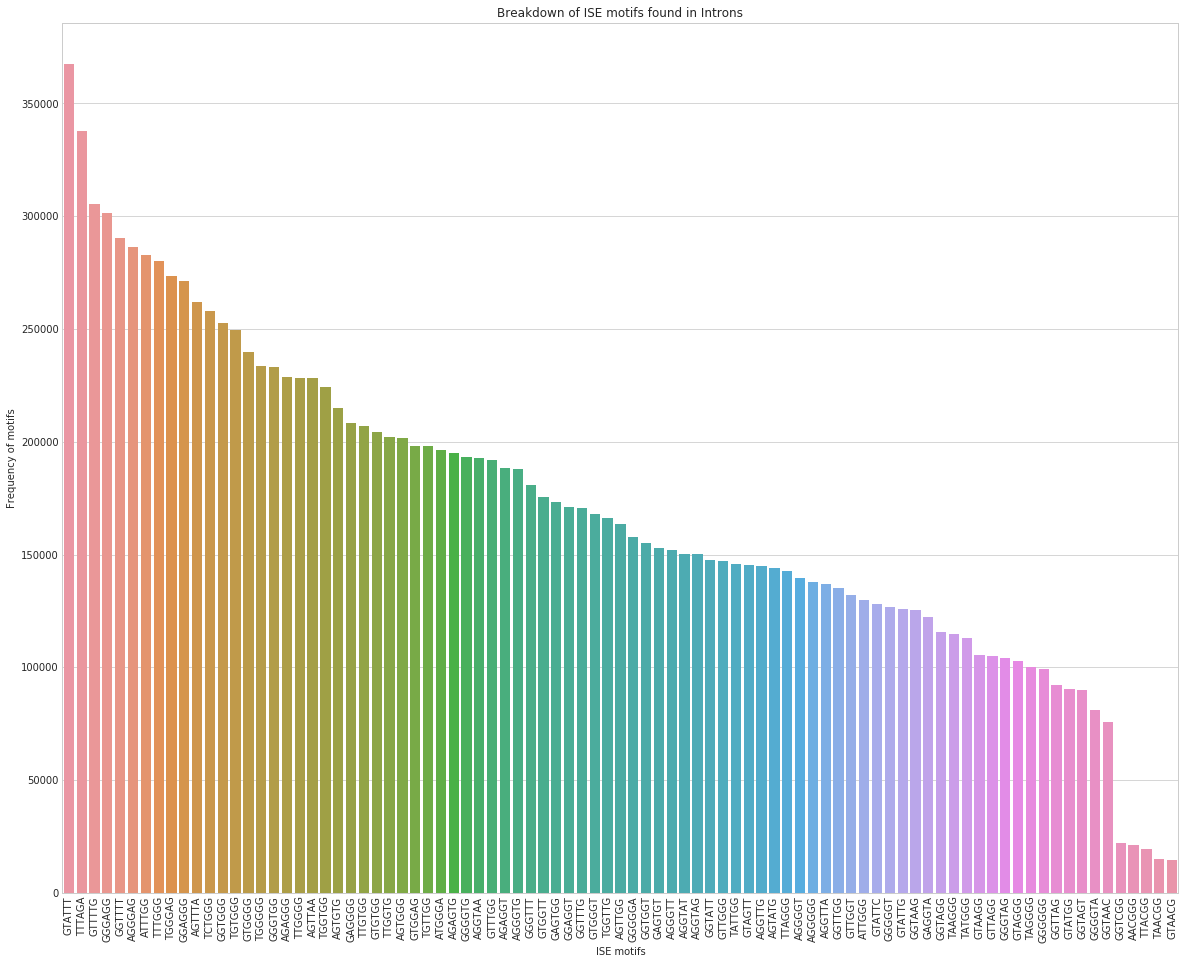

In [12]:
# Let's break this down by ISE and ISSs: First ISE
# Look for overrepresented ISEs in introns
ISREs_inIntron_Count_df_JustISEs = ISREs_inIntron_Count_df[ISREs_inIntron_Count_df["ISREmotifs"].isin(ISE_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_inIntron_Count_df_JustISEs)
plt.xlabel("ISE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs found in Introns")
plt.show()

In [13]:
# Lets sort the ISE motif counts by motif
ISREs_inIntron_Count_df_JustISEs_sorted = ISREs_inIntron_Count_df_JustISEs.sort_values(["ISREmotifs"])
print ISREs_inIntron_Count_df_JustISEs_sorted.shape
ISREs_inIntron_Count_df_JustISEs_sorted["Numbers"] = pd.to_numeric(ISREs_inIntron_Count_df_JustISEs_sorted["Numbers"])
ISREs_inIntron_Count_df_JustISEs_sorted.head()

(87, 2)


,ISREmotifs,Numbers
133,AACGGG,21150
28,AGAGGG,228794
53,AGAGGT,188241
47,AGAGTG,195089
7,AGGGAG,286340


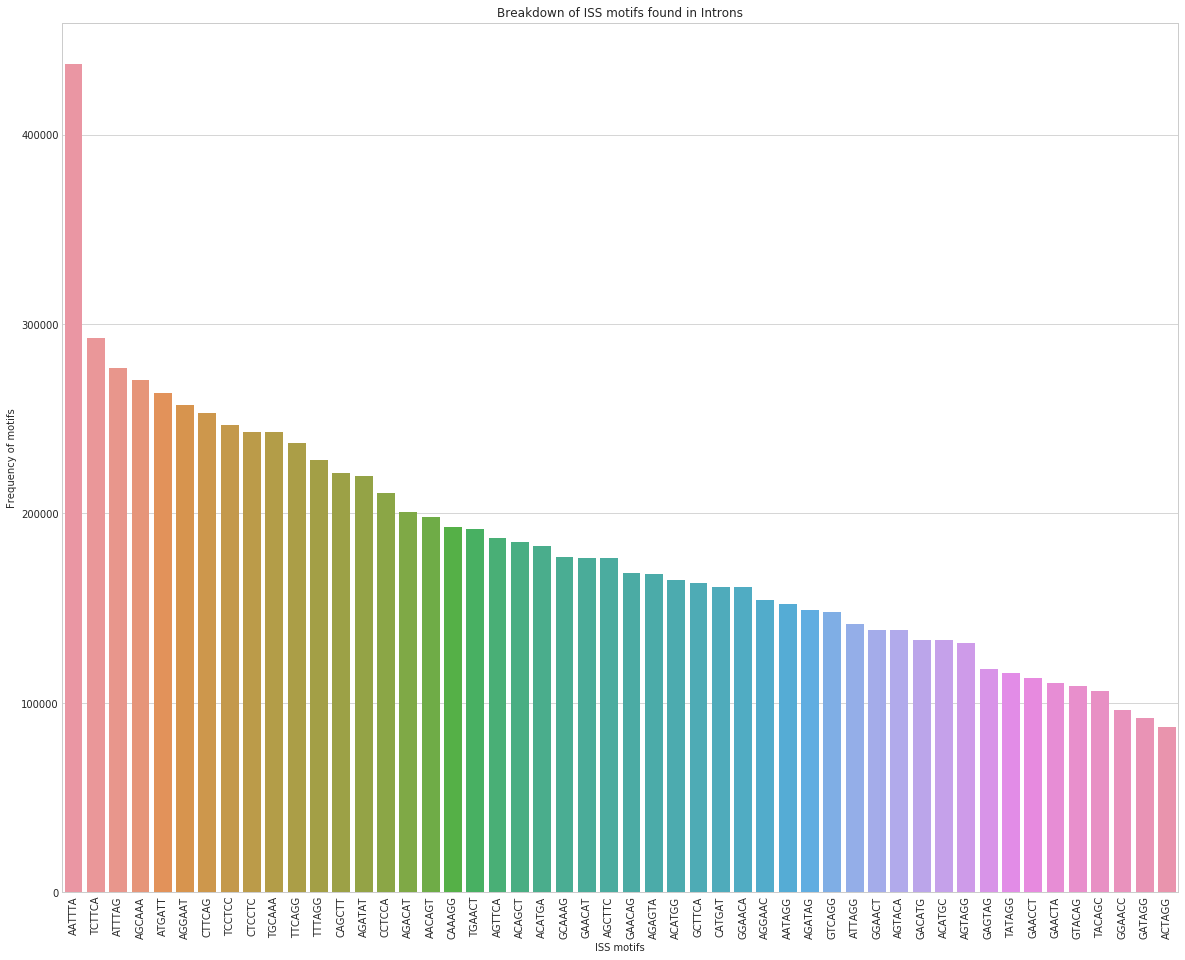

In [9]:
# Look for overrepresented ISSs in introns
ISREs_inIntron_Count_df_JustISSs = ISREs_inIntron_Count_df[ISREs_inIntron_Count_df["ISREmotifs"].isin(ISS_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_inIntron_Count_df_JustISSs)
plt.xlabel("ISS motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs found in Introns")
plt.show()

In [10]:
# Lets sort the ISE motif counts by motif
ISREs_inIntron_Count_df_JustISSs_sorted = ISREs_inIntron_Count_df_JustISSs.sort_values(["ISREmotifs"])
print ISREs_inIntron_Count_df_JustISSs_sorted.shape
ISREs_inIntron_Count_df_JustISSs_sorted.head()

(50, 2)


,ISREmotifs,Numbers
45,AACAGT,197871
79,AATAGG,152121
0,AATTTA,437252
56,ACAGCT,184786
57,ACATGA,182867


In [14]:
# This is a function that will find mutations that will create or destroy ISRE motifs
def getMutationsThatCreateOrDestroyISREMotifs(ISREfile, mutation_seqfile, mutationsOfInterest, mutsite, create):
    # Open the file containing ISRE motifs
    ISRE_motifs = pd.read_csv(ISREfile,header=None)
    print ISRE_motifs.head()
    # Open file with mutations and sequences surrounding mutations
    mutations_withSeq = pd.read_csv(mutation_seqfile,sep="\t",header=None)
    print mutations_withSeq.shape
    # Open file that contains IDs of mutations of interest
    muts_Of_interest = pd.read_csv(mutationsOfInterest,sep="\t",header=None)
    print muts_Of_interest.shape
    
    # Subset muations_withSeq data and only have ones that contains IDs of mutations of interest
    muts_Of_interest_withSeq = mutations_withSeq[mutations_withSeq[9].isin(muts_Of_interest[9])]
    print muts_Of_interest_withSeq.shape
    
    if create == True:
        index_for_seq = 14
    else:
        index_for_seq = 13
    
    # Create a dictionary that stores the mutated sequence as values with mutation id as the key
    muts_dict = pd.Series(muts_Of_interest_withSeq[index_for_seq].values,index=muts_Of_interest_withSeq[9].values).to_dict()
    
    # These are the lists that are going to contain the mutation ids for mutations that result in new ISRE motifs
    mutations_Have_Motifs = []

    # Go through every record in mutation file
    for mut in muts_dict.keys():
        mut_seq = muts_dict[mut]
        mutatedISREmotifs_for_mut = []
        for i in ISRE_motifs[0].values:
            x = [[m.start(), m.end()] for m in re2.finditer(i, mut_seq,overlapped=True) if mutsite in range(m.start(), m.end())]
            if len(x) != 0:
                mutatedISREmotifs_for_mut.append(i)
        if len(mutatedISREmotifs_for_mut) > 0:
            mutations_Have_Motifs.append([mut,mutatedISREmotifs_for_mut])

    return mutations_Have_Motifs

In [15]:
# This is a function that will find mutations that will create or destroy ISRE motifs
def getMutationsThatCreateOrDestroyISREMotifs_Modify(ISREfile, mutation_seqfile, mutationsOfInterest, mutsite, create):
    # Open the file containing ISRE motifs
    ISRE_motifs = pd.read_csv(ISREfile,header=None)
    print ISRE_motifs.head()
    # Open file with mutations and sequences surrounding mutations
    mutations_withSeq = pd.read_csv(mutation_seqfile,sep="\t",header=None)
    print mutations_withSeq.shape
    # Open file that contains IDs of mutations of interest
    muts_Of_interest = pd.read_csv(mutationsOfInterest,sep="\t",header=None)
    print muts_Of_interest.shape
    
    # Subset muations_withSeq data and only have ones that contains IDs of mutations of interest
    muts_Of_interest_withSeq = mutations_withSeq[mutations_withSeq[9].isin(muts_Of_interest[9])]
    print muts_Of_interest_withSeq.shape
    
    if create == True:
        index_for_seq = 14
    else:
        index_for_seq = 13
    
    # We just want to grab the 10 base pair sequence around the mutant since we want to check if
    # WT base or mutant base is within the 6 base pair ISRE
    muts_Seq_JustAroundMut = muts_Of_interest_withSeq[index_for_seq].str.slice(mutsite-5,mutsite+6)
    
    # These are the dictionary that are going to contain the mutation ids for mutations that result in new ISRE motifs
    # as the keys and the values will be the motifs found 
    mutations_Have_Motifs = {}
    
    # Go through every ISRE
    for motif in ISRE_motifs[0].values:
        muts_WithMotif = muts_Of_interest_withSeq[muts_Seq_JustAroundMut.str.contains(motif)][9]
        #print muts_WithMotif.shape
        #print muts_WithMotif.head()
        for mut in muts_WithMotif.values:
            mutations_Have_Motifs[mut] = mutations_Have_Motifs.get(mut,[])+[motif]

    return mutations_Have_Motifs

### Investigate enrichment of ISRE motifs that are created by DAVs

In [91]:
# Look for ISRE motifs in the sequences around the mutation that contain the mutated base and check if the mutated base
# is within the ISRE motif found
Muts_Create_New_ISREs = getMutationsThatCreateOrDestroyISREMotifs_Modify("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",25,True)
print len(Muts_Create_New_ISREs.keys())
#Muts_Create_New_ISREs[0:5]

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(7742, 15)
(7124, 13)
(7124, 15)
1299


['GGGTAG', 'TAAGGG', 'AGTAGG', 'TGGTTG', 'AGTAGG', 'AGGTAT', 'GGTAGG', 'GGGTAG', 'AGGGTG', 'GTTTTG']


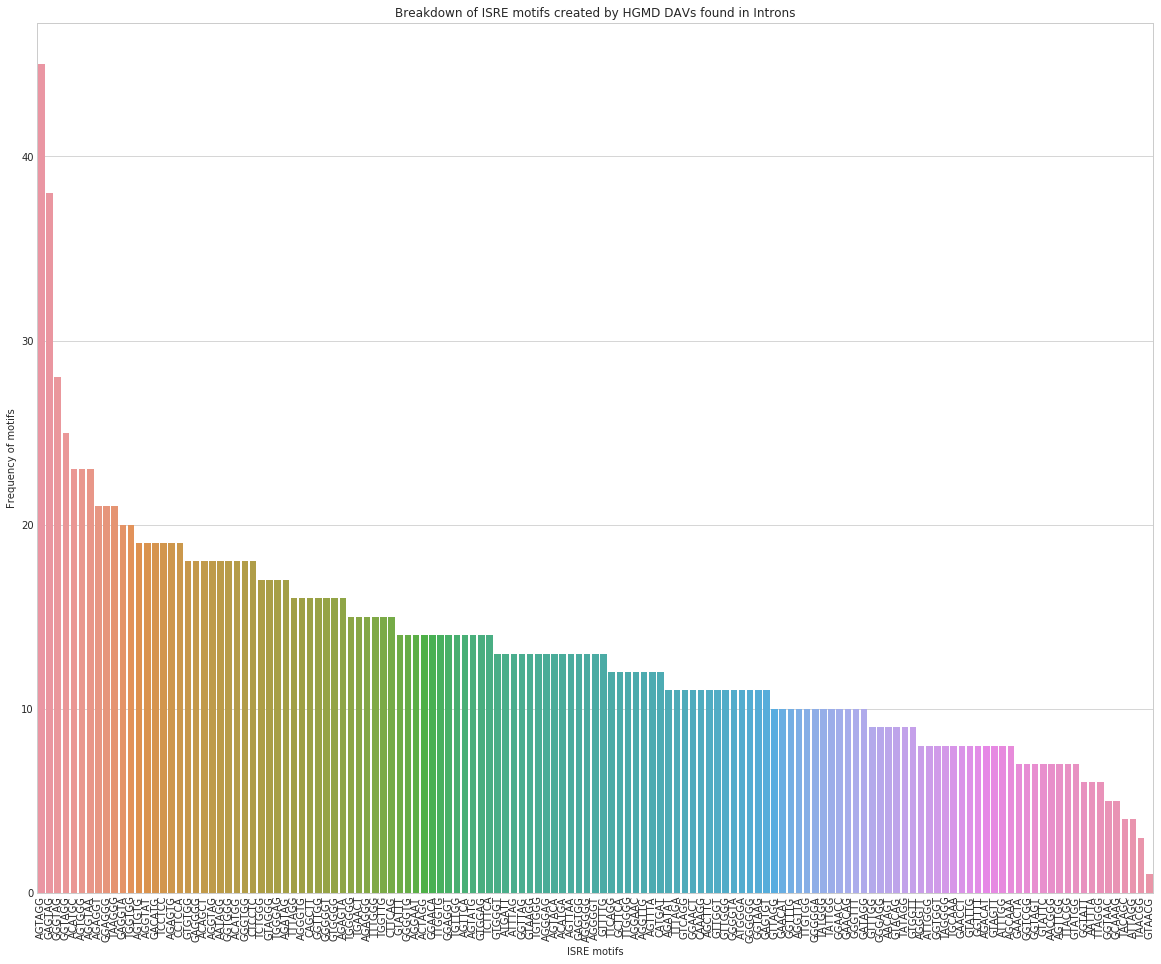

In [92]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_created = []
for val in Muts_Create_New_ISREs.values():
    ISREs_created.extend(val)
print ISREs_created[0:10]
ISREs_created_Count = pd.Series(ISREs_created).value_counts()
ISREs_created_counts_df = pd.DataFrame({"Numbers":ISREs_created_Count.values,"ISREmotifs":ISREs_created_Count.index.values},columns=["ISREmotifs","Numbers"])
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_created_counts_df)
plt.xlabel("ISRE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [93]:
# Look at the top 10 motifs represented
ISREs_created_counts_df.head(n=10)

,ISREmotifs,Numbers
0,AGTAGG,45
1,GAGTAG,38
2,GGGTAG,28
3,GGTAGG,25
4,ACATGC,23
5,AGTGGG,23
6,AGGTAA,23
7,AGAGGT,21
8,GGAGGG,21
9,TAAGGG,21


We need to get normalize the counts to ISRE motif counts found in introns

In [94]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_created_counts_df_sorted = ISREs_created_counts_df.sort_values(["ISREmotifs"])
print ISREs_created_counts_df_sorted.shape
ISREs_created_counts_df_sorted.head()

(137, 2)


,ISREmotifs,Numbers
104,AACAGT,9
124,AACGGG,7
22,AATAGG,18
129,AATTTA,6
20,ACAGCT,18


In [95]:
# Add a new column that is the normalized counts
ISREs_created_counts_df_sorted["Normalized_Count"] = (10**8)*ISREs_created_counts_df_sorted["Numbers"]/(sum(ISREs_created_counts_df_sorted["Numbers"])*ISREs_inIntron_Count_df_sorted["Numbers"])
print ISREs_created_counts_df_sorted.shape
ISREs_created_counts_df_sorted.head()

(137, 3)


,ISREmotifs,Numbers,Normalized_Count
104,AACAGT,9,3.906789
124,AACGGG,7,4.045090
22,AATAGG,18,4.120265
129,AATTTA,6,3.829407
20,ACAGCT,18,4.012761


In [96]:
# Re-sort by Normalized Count
ISREs_created_counts_df_sorted_ResortByNormalizedCount = ISREs_created_counts_df_sorted.sort_values(["Normalized_Count"],ascending=False)

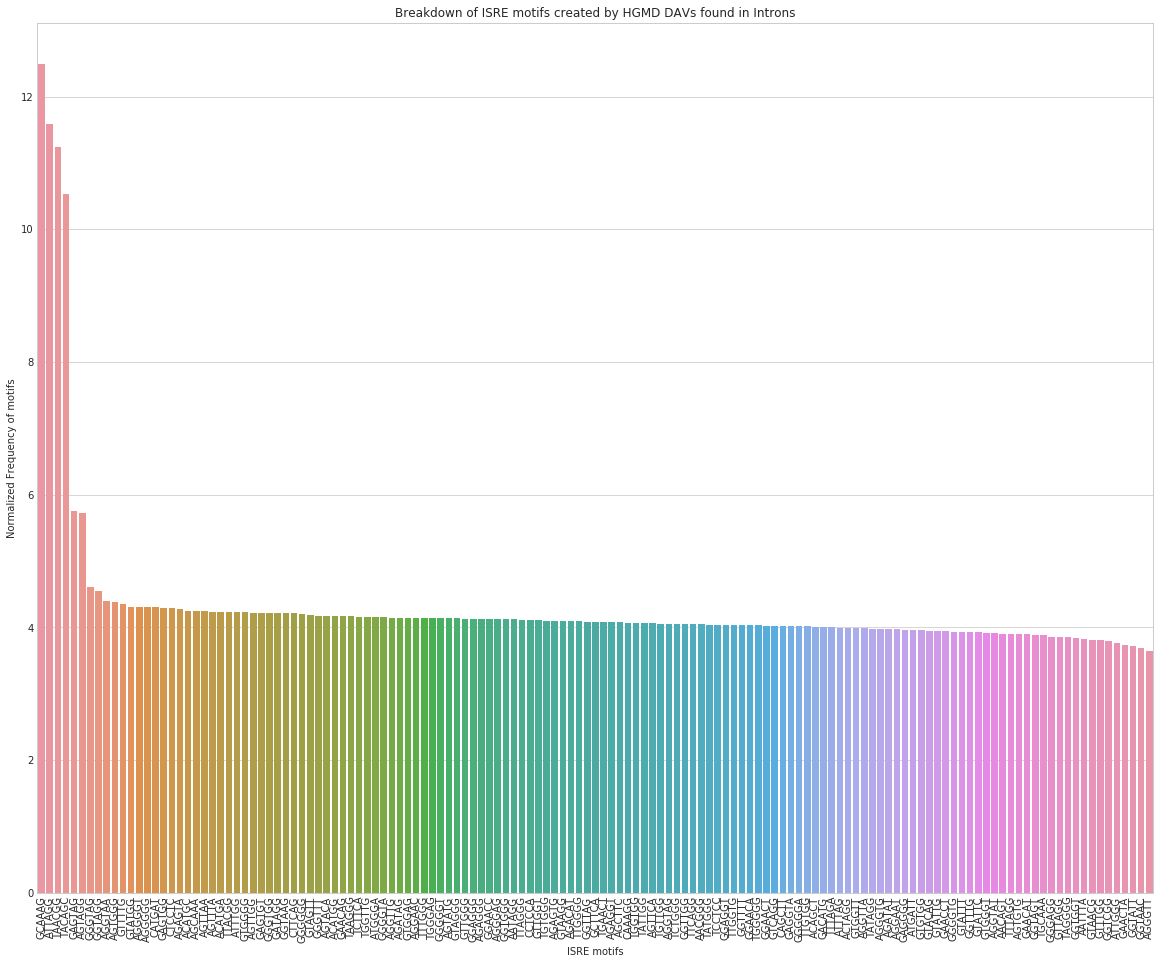

In [97]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_created_counts_df_sorted_ResortByNormalizedCount)
plt.xlabel("ISRE motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [98]:
# Take a look at the top 10
ISREs_created_counts_df_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
132,GCAAAG,5,12.483916
134,ATTAGG,4,11.588568
135,TAACGG,3,11.246625
133,TACAGC,4,10.524502
1,GAGTAG,38,5.757479
0,AGTAGG,45,5.727072
2,GGGTAG,28,4.614410
3,GGTAGG,25,4.552664
6,AGGTAA,23,4.405116
5,AGTGGG,23,4.376482


### Investigate enrichment of ISE motifs that are created by DAVs

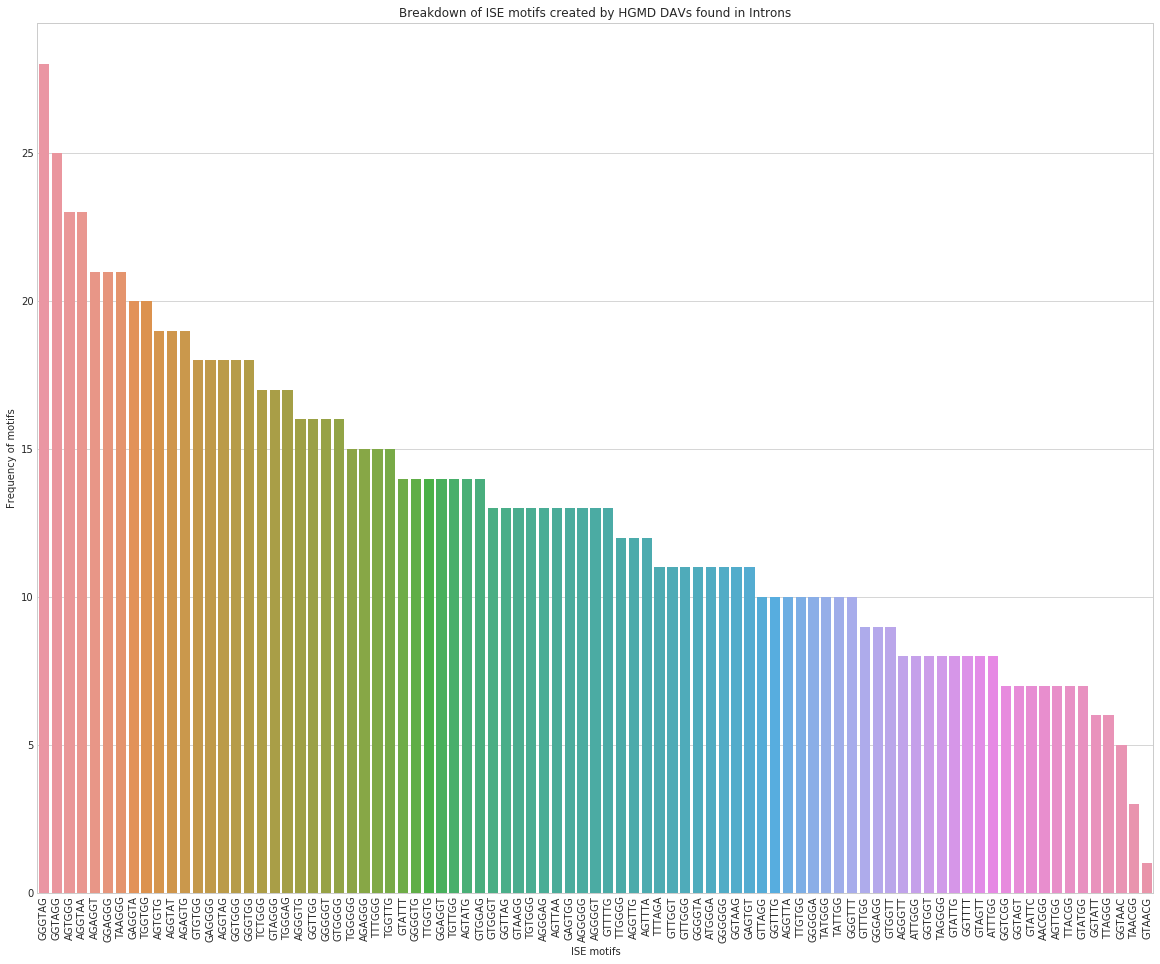

In [99]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_created_Count_df_JustISEs = ISREs_created_counts_df[ISREs_created_counts_df["ISREmotifs"].isin(ISE_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_created_Count_df_JustISEs)
plt.xlabel("ISE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [100]:
# Look at the top 10 motifs represented
ISREs_created_Count_df_JustISEs.head(n=10)

,ISREmotifs,Numbers
2,GGGTAG,28
3,GGTAGG,25
5,AGTGGG,23
6,AGGTAA,23
7,AGAGGT,21
8,GGAGGG,21
9,TAAGGG,21
10,GAGGTA,20
11,TGGTGG,20
12,AGTGTG,19


We need to get normalize the counts to ISE motif counts found in introns

In [101]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_created_Count_df_JustISEs_sorted = ISREs_created_Count_df_JustISEs.sort_values(["ISREmotifs"])
print ISREs_created_Count_df_JustISEs_sorted.shape
ISREs_created_Count_df_JustISEs_sorted["Numbers"] = ISREs_created_Count_df_JustISEs_sorted["Numbers"].astype(float)
ISREs_created_Count_df_JustISEs_sorted.head()

(87, 2)


,ISREmotifs,Numbers
124,AACGGG,7.0
40,AGAGGG,15.0
7,AGAGGT,21.0
16,AGAGTG,19.0
62,AGGGAG,13.0


In [102]:
# Add a new column that is the normalized counts
ISREs_created_Count_df_JustISEs_sorted["Normalized_Count"] = (10**8)*ISREs_created_Count_df_JustISEs_sorted["Numbers"].values/(sum(ISREs_created_Count_df_JustISEs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISEs_sorted["Numbers"].values)
print ISREs_created_Count_df_JustISEs_sorted.shape
ISREs_created_Count_df_JustISEs_sorted.head()

(87, 3)


,ISREmotifs,Numbers,Normalized_Count
124,AACGGG,7.0,29.630194
40,AGAGGG,15.0,5.869397
7,AGAGGT,21.0,9.987387
16,AGAGTG,19.0,8.719019
62,AGGGAG,13.0,4.064510


In [103]:
# Re-sort by Normalized Count
ISREs_created_Count_df_JustISEs_sorted_ResortByNormalizedCount = ISREs_created_Count_df_JustISEs_sorted.sort_values(["Normalized_Count"],ascending=False)

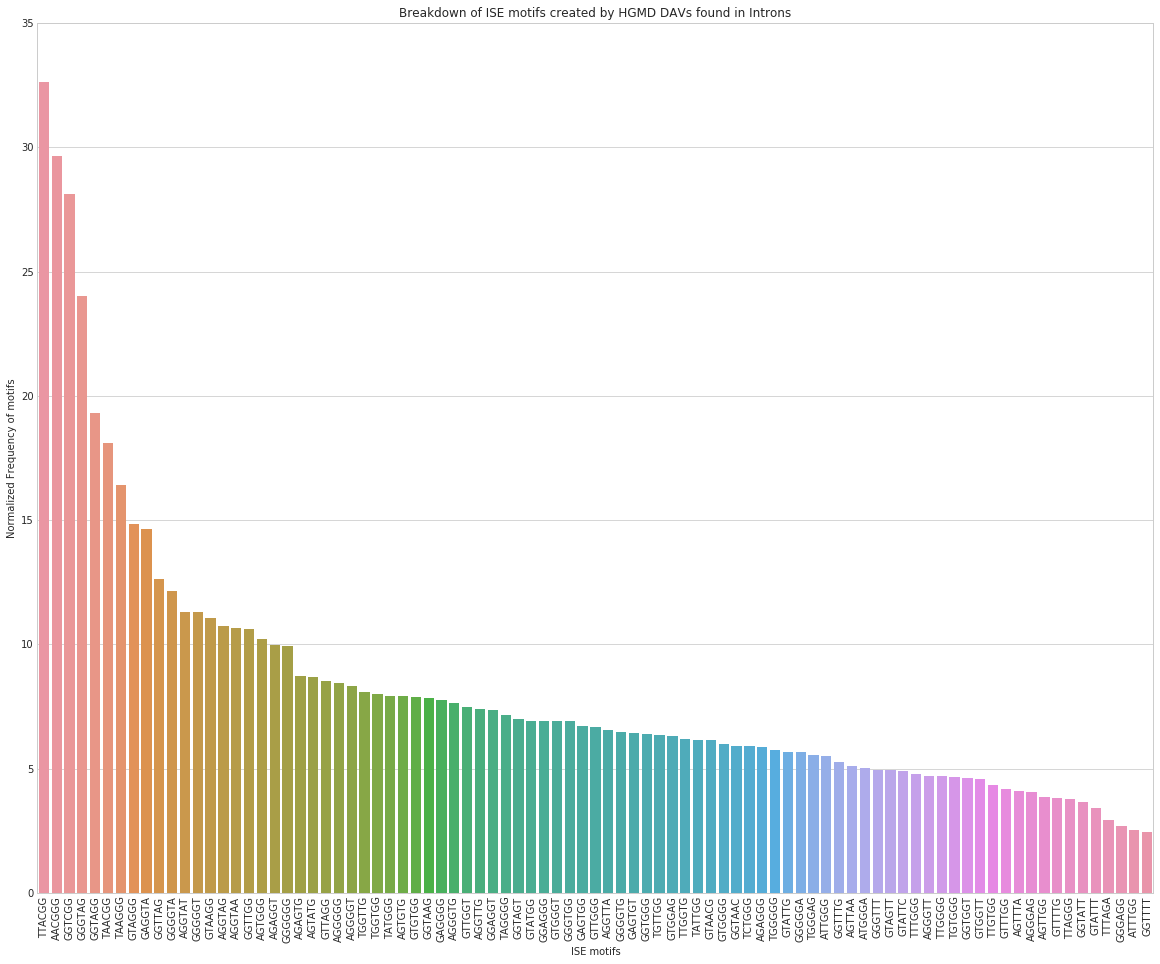

In [108]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_created_Count_df_JustISEs_sorted_ResortByNormalizedCount)
plt.ylim([0,35])
plt.xlabel("ISE motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [105]:
# Take a look at the top 10
ISREs_created_Count_df_JustISEs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
126,TTACGG,7.0,32.625916
124,AACGGG,7.0,29.630194
121,GGTCGG,7.0,28.117310
2,GGGTAG,28.0,24.027475
3,GGTAGG,25.0,19.318273
135,TAACGG,3.0,18.093273
9,TAAGGG,21.0,16.402623
28,GTAGGG,17.0,14.839014
10,GAGGTA,20.0,14.653613
59,GGTTAG,13.0,12.639628


In [109]:
# Write the ISEs created by DAVs into a file
ISREs_created_Count_df_JustISEs_sorted_ResortByNormalizedCount.to_csv("../temp/ISEs_created_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)

### Investigate enrichment of ISS motifs that are created by DAVs

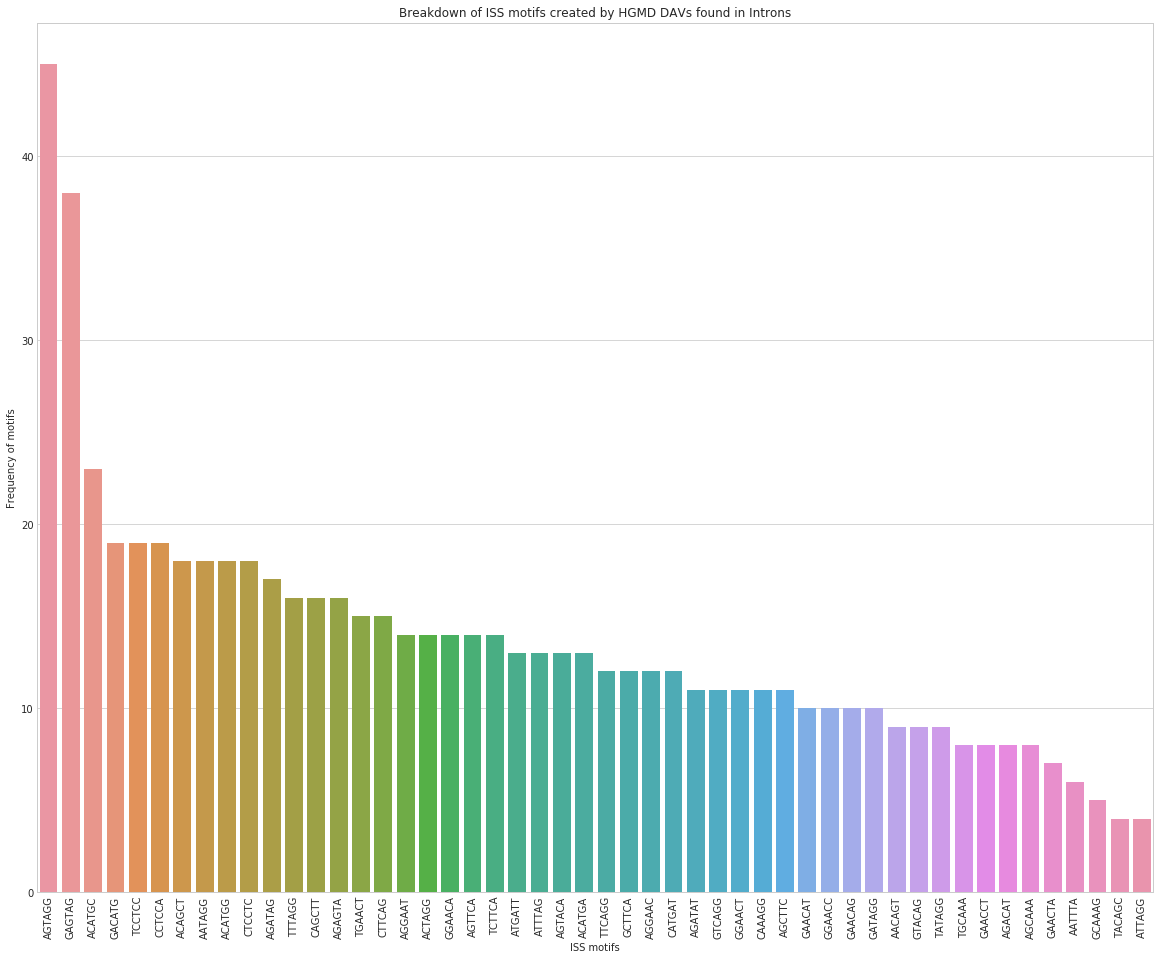

In [110]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_created_Count_df_JustISSs = ISREs_created_counts_df[ISREs_created_counts_df["ISREmotifs"].isin(ISS_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_created_Count_df_JustISSs)
plt.xlabel("ISS motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [111]:
# Look at the top 10 motifs represented
ISREs_created_Count_df_JustISSs.head(n=10)

,ISREmotifs,Numbers
0,AGTAGG,45
1,GAGTAG,38
4,ACATGC,23
14,GACATG,19
15,TCCTCC,19
17,CCTCCA,19
20,ACAGCT,18
22,AATAGG,18
24,ACATGG,18
26,CTCCTC,18


We need to get normalize the counts to ISS motif counts found in introns

In [112]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_created_Count_df_JustISSs_sorted = ISREs_created_Count_df_JustISSs.sort_values(["ISREmotifs"])
print ISREs_created_Count_df_JustISSs_sorted.shape
ISREs_created_Count_df_JustISSs_sorted["Numbers"] = ISREs_created_Count_df_JustISSs_sorted["Numbers"].astype(float)
ISREs_created_Count_df_JustISSs_sorted.head()

(50, 2)


,ISREmotifs,Numbers
104,AACAGT,9.0
22,AATAGG,18.0
129,AATTTA,6.0
20,ACAGCT,18.0
64,ACATGA,13.0


In [113]:
# Add a new column that is the normalized counts
ISREs_created_Count_df_JustISSs_sorted["Normalized_Count"] = (10**8)*ISREs_created_Count_df_JustISSs_sorted["Numbers"].values/(sum(ISREs_created_Count_df_JustISSs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISSs_sorted["Numbers"].values)
print ISREs_created_Count_df_JustISSs_sorted.shape
ISREs_created_Count_df_JustISSs_sorted.head()

(50, 3)


,ISREmotifs,Numbers,Normalized_Count
104,AACAGT,9.0,6.688850
22,AATAGG,18.0,17.401009
129,AATTTA,6.0,2.017951
20,ACAGCT,18.0,14.324997
64,ACATGA,13.0,10.454400


In [114]:
# Re-sort by Normalized Count
ISREs_created_Count_df_JustISSs_sorted_ResortByNormalizedCount = ISREs_created_Count_df_JustISSs_sorted.sort_values(["Normalized_Count"],ascending=False)

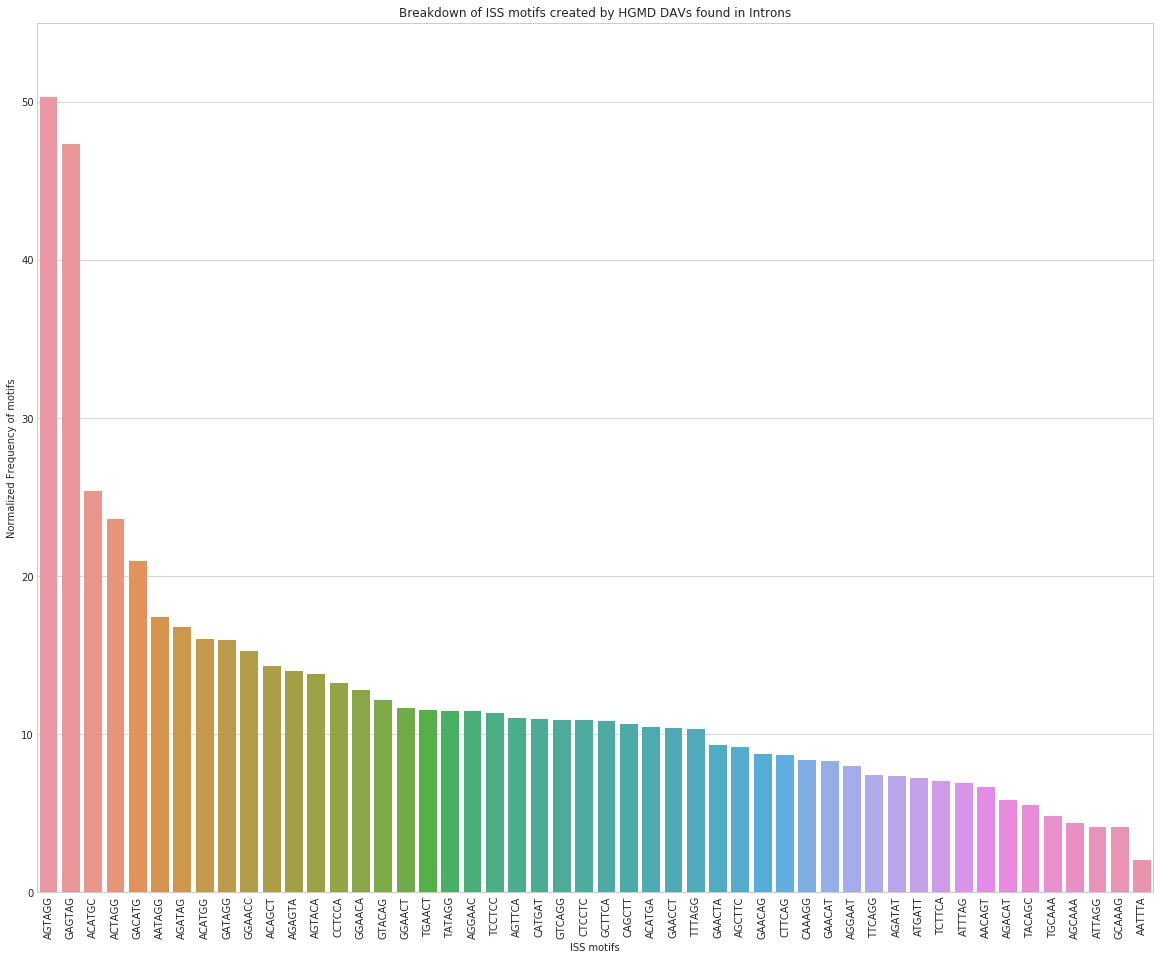

In [118]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_created_Count_df_JustISSs_sorted_ResortByNormalizedCount)
plt.ylim([0,55])
plt.xlabel("ISS motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs created by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [116]:
# Take a look at the top 10
ISREs_created_Count_df_JustISSs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
0,AGTAGG,45.0,50.303655
1,GAGTAG,38.0,47.349500
4,ACATGC,23.0,25.397044
47,ACTAGG,14.0,23.612799
14,GACATG,19.0,20.953106
22,AATAGG,18.0,17.401009
30,AGATAG,17.0,16.767495
24,ACATGG,18.0,16.035200
101,GATAGG,10.0,15.943064
98,GGAACC,10.0,15.271064


In [117]:
# Write the ISSs created by DAVs into a file
ISREs_created_Count_df_JustISSs_sorted_ResortByNormalizedCount.to_csv("../temp/ISSs_created_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)

### Investigate enrichment of ISRE motifs that are abolished by DAVs

In [16]:
# Look for ISRE motifs in the sequences around the mutation that contain the WT base and check if the WT base
# is within the ISRE motif found
Muts_Destroy_ISREs = getMutationsThatCreateOrDestroyISREMotifs_Modify("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",25,False)
print len(Muts_Destroy_ISREs.keys())

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(7742, 15)
(7124, 13)
(7124, 15)
1255


['GTATTT', 'GAGGTA', 'AGGTAG', 'GGTAGG', 'GGAGGT', 'AGTTTA', 'GGGAGG', 'GGAGGT', 'GTAACG', 'GTTTGG']


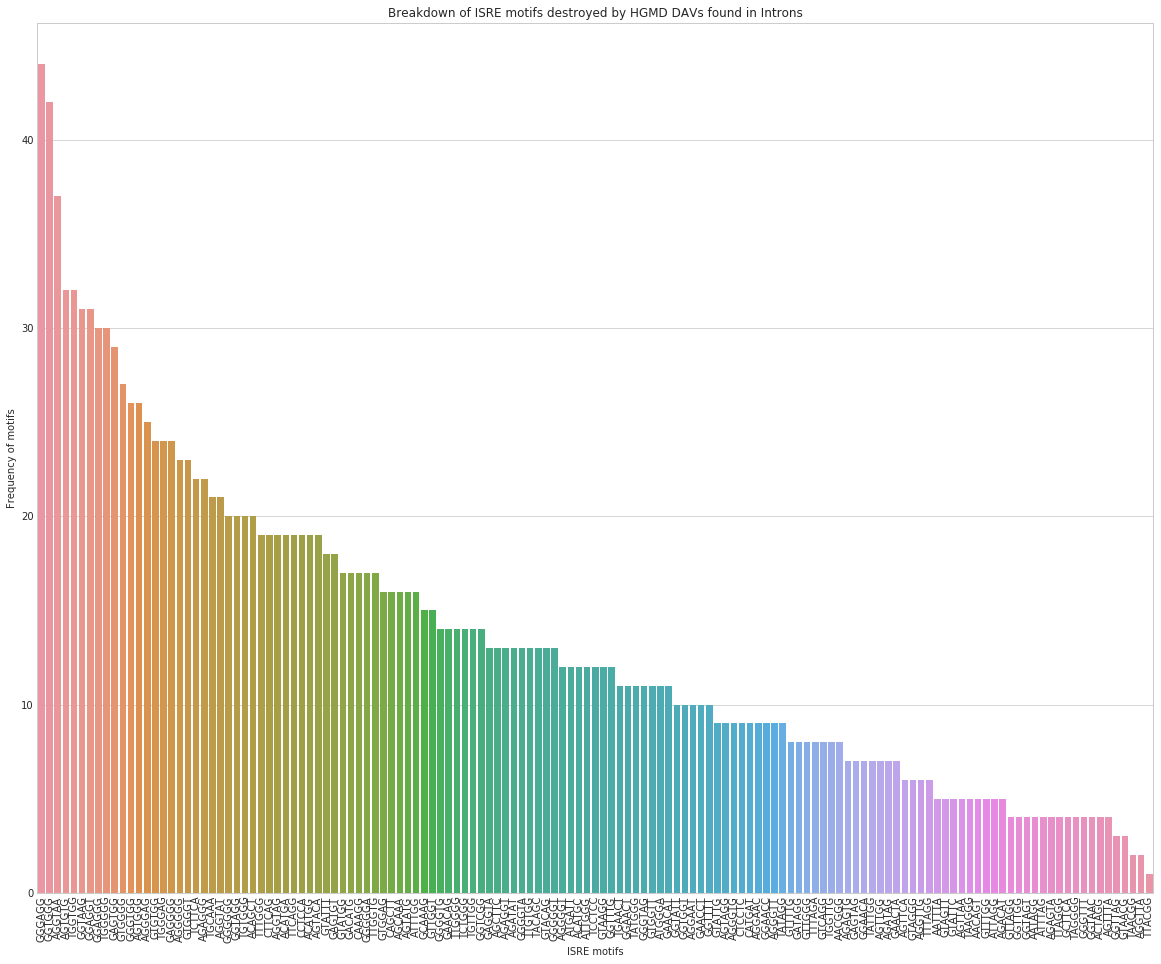

In [17]:
# Look for overrepresented ISREs that are abolished by DAVs
ISREs_destroyed = []
for val in Muts_Destroy_ISREs.values():
    ISREs_destroyed.extend(val)
print ISREs_destroyed[0:10]
ISREs_destroyed_Count = pd.Series(ISREs_destroyed).value_counts()
ISREs_destroyed_counts_df = pd.DataFrame({"Numbers":ISREs_destroyed_Count.values,"ISREmotifs":ISREs_destroyed_Count.index.values},columns=["ISREmotifs","Numbers"])
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_destroyed_counts_df)
plt.xlabel("ISRE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [18]:
# Look at the top 10 motifs represented
ISREs_destroyed_counts_df.head(n=10)

,ISREmotifs,Numbers
0,GGGAGG,44
1,GGTGGG,42
2,AGGTAA,37
3,AGTGTG,32
4,TGGTGG,32
5,GGTAAG,31
6,GGAGGT,31
7,GGAGGG,30
8,TGGGGG,30
9,GAGTGG,29


We need to get normalize the counts to ISRE motif counts found in introns

In [19]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_destroyed_counts_df_sorted = ISREs_destroyed_counts_df.sort_values(["ISREmotifs"])
print ISREs_destroyed_counts_df_sorted.shape
ISREs_destroyed_counts_df_sorted.head()

(137, 2)


,ISREmotifs,Numbers
115,AACAGT,5
98,AACGGG,8
122,AATAGG,4
110,AATTTA,5
26,ACAGCT,20


In [20]:
# Add a new column that is the normalized counts
ISREs_destroyed_counts_df_sorted["Normalized_Count"] = (10**8)*ISREs_destroyed_counts_df_sorted["Numbers"]/(sum(ISREs_destroyed_counts_df_sorted["Numbers"])*ISREs_inIntron_Count_df_sorted["Numbers"])
print ISREs_destroyed_counts_df_sorted.shape
ISREs_destroyed_counts_df_sorted.head()

(137, 3)


,ISREmotifs,Numbers,Normalized_Count
115,AACAGT,5,2.462811
98,AACGGG,8,3.222626
122,AATAGG,4,2.169758
110,AATTTA,5,2.346766
26,ACAGCT,20,4.658988


In [21]:
# Re-sort by Normalized Count
ISREs_destroyed_counts_df_sorted_ResortByNormalizedCount = ISREs_destroyed_counts_df_sorted.sort_values(["Normalized_Count"],ascending=False)

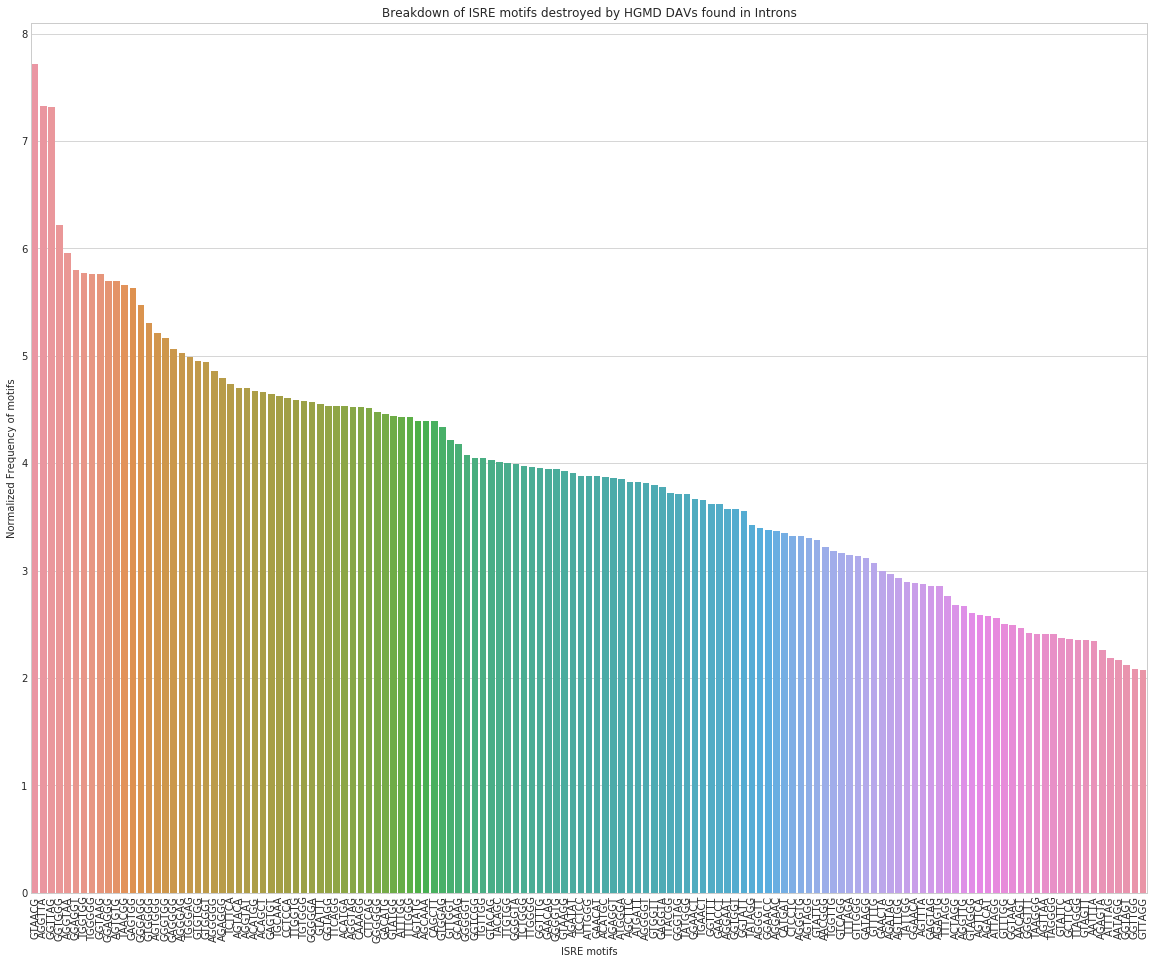

In [22]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_destroyed_counts_df_sorted_ResortByNormalizedCount)
plt.xlabel("ISRE motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [23]:
# Take a look at the top 10
ISREs_destroyed_counts_df_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
133,GTAACG,3,7.713103
135,AGGTTA,2,7.326513
132,GGTTAG,3,7.319281
1,GGTGGG,42,6.218195
2,AGGTAA,37,5.958353
6,GGAGGT,31,5.801731
4,TGGTGG,32,5.774614
8,TGGGGG,30,5.766322
5,GGTAAG,31,5.764019
7,GGAGGG,30,5.697148


### Investigate enrichment of ISE motifs that are destroyed by DAVs

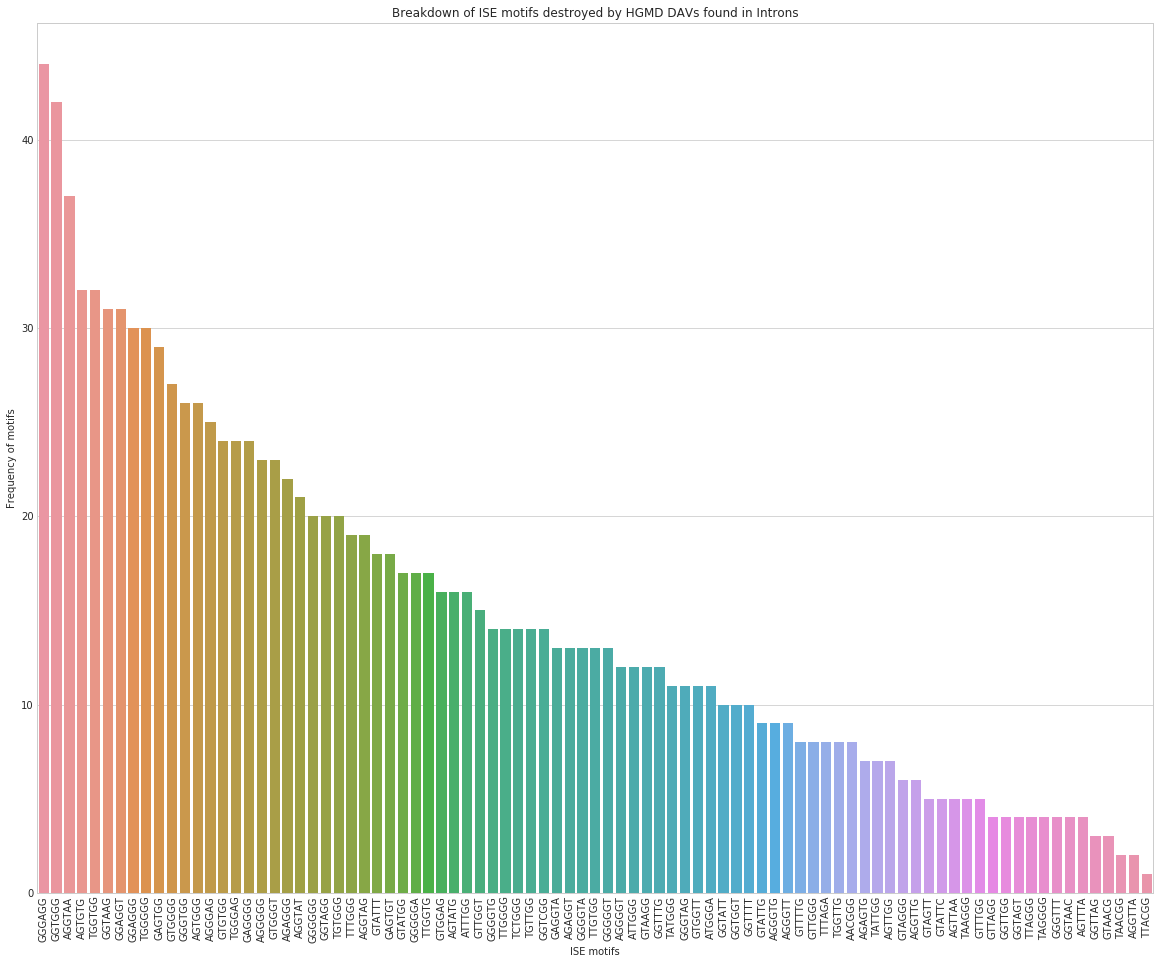

In [24]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_destroyed_Count_df_JustISEs = ISREs_destroyed_counts_df[ISREs_destroyed_counts_df["ISREmotifs"].isin(ISE_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_destroyed_Count_df_JustISEs)
plt.xlabel("ISE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [25]:
# Look at the top 10 motifs represented
ISREs_destroyed_Count_df_JustISEs.head(n=10)

,ISREmotifs,Numbers
0,GGGAGG,44
1,GGTGGG,42
2,AGGTAA,37
3,AGTGTG,32
4,TGGTGG,32
5,GGTAAG,31
6,GGAGGT,31
7,GGAGGG,30
8,TGGGGG,30
9,GAGTGG,29


We need to get normalize the counts to ISE motif counts found in introns

In [26]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_destroyed_Count_df_JustISEs_sorted = ISREs_destroyed_Count_df_JustISEs.sort_values(["ISREmotifs"])
print ISREs_destroyed_Count_df_JustISEs_sorted.shape
ISREs_destroyed_Count_df_JustISEs_sorted["Numbers"] = ISREs_destroyed_Count_df_JustISEs_sorted["Numbers"].astype(float)
ISREs_destroyed_Count_df_JustISEs_sorted.head()

(87, 2)


,ISREmotifs,Numbers
98,AACGGG,8.0
20,AGAGGG,22.0
57,AGAGGT,13.0
99,AGAGTG,7.0
13,AGGGAG,25.0


In [27]:
# Add a new column that is the normalized counts
ISREs_destroyed_Count_df_JustISEs_sorted["Normalized_Count"] = (10**8)*ISREs_destroyed_Count_df_JustISEs_sorted["Numbers"].values/(sum(ISREs_destroyed_Count_df_JustISEs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISEs_sorted["Numbers"].values)
print ISREs_destroyed_Count_df_JustISEs_sorted.shape
ISREs_destroyed_Count_df_JustISEs_sorted.head()

(87, 3)


,ISREmotifs,Numbers,Normalized_Count
98,AACGGG,8.0,29.643463
20,AGAGGG,22.0,7.535765
57,AGAGGT,13.0,5.412258
99,AGAGTG,7.0,2.811995
13,AGGGAG,25.0,6.842382


In [28]:
# Re-sort by Normalized Count
ISREs_destroyed_Count_df_JustISEs_sorted_ResortByNormalizedCount = ISREs_destroyed_Count_df_JustISEs_sorted.sort_values(["Normalized_Count"],ascending=False)

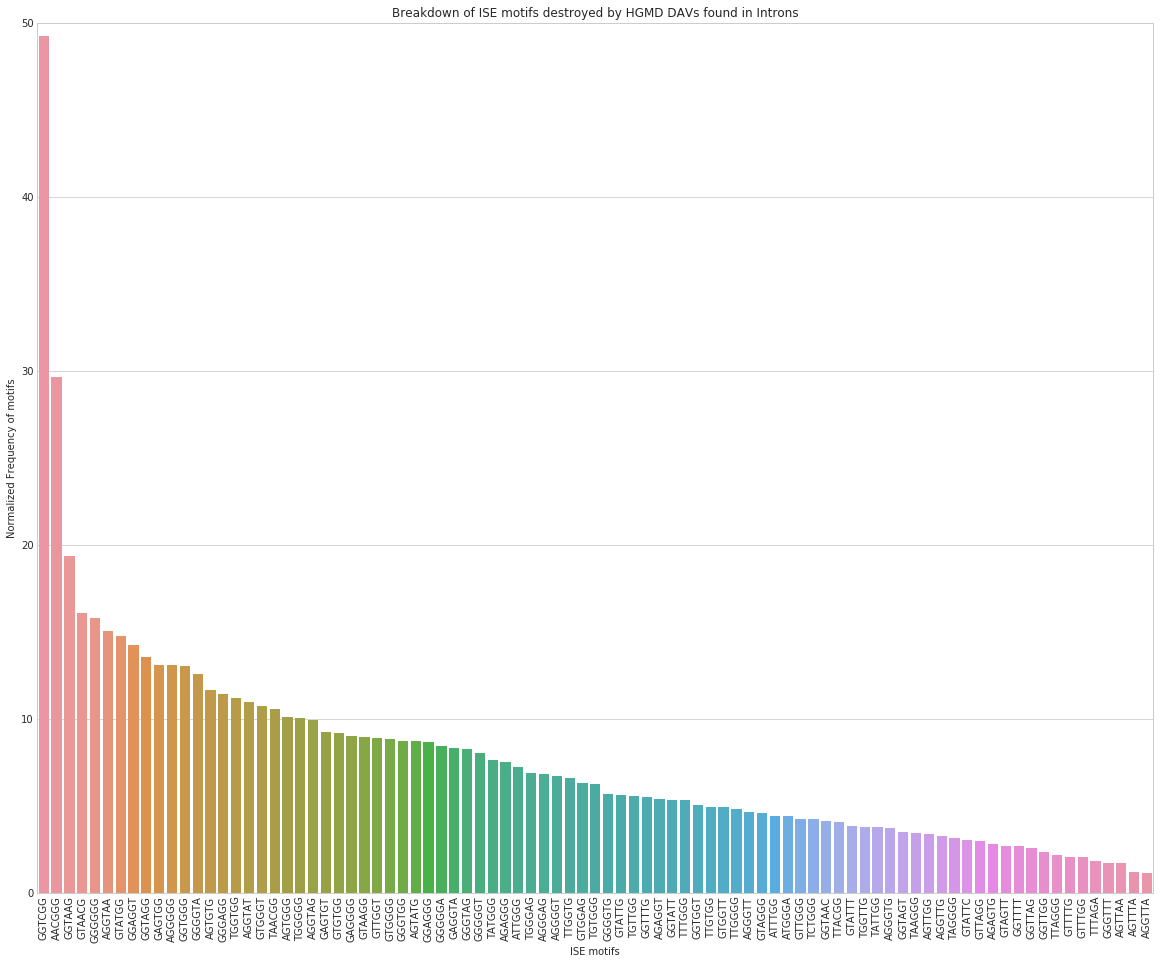

In [31]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_destroyed_Count_df_JustISEs_sorted_ResortByNormalizedCount)
plt.xlabel("ISE motifs")
plt.ylim([0,50])
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [30]:
# Take a look at the top 10
ISREs_destroyed_Count_df_JustISEs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
54,GGTCGG,14.0,49.227328
98,AACGGG,8.0,29.643463
5,GGTAAG,31.0,19.369879
133,GTAACG,3.0,16.106715
23,GGGGGG,20.0,15.786221
2,AGGTAA,37.0,15.023738
37,GTATGG,17.0,14.737051
6,GGAGGT,31.0,14.220633
24,GGTAGG,20.0,13.528847
9,GAGTGG,29.0,13.119937


In [32]:
# Write the ISREs destroyed by DAVs into a file
ISREs_destroyed_Count_df_JustISEs_sorted_ResortByNormalizedCount.to_csv("../temp/ISEs_destroyed_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)

### Investigate enrichment of ISS motifs that are destroyed by DAVs

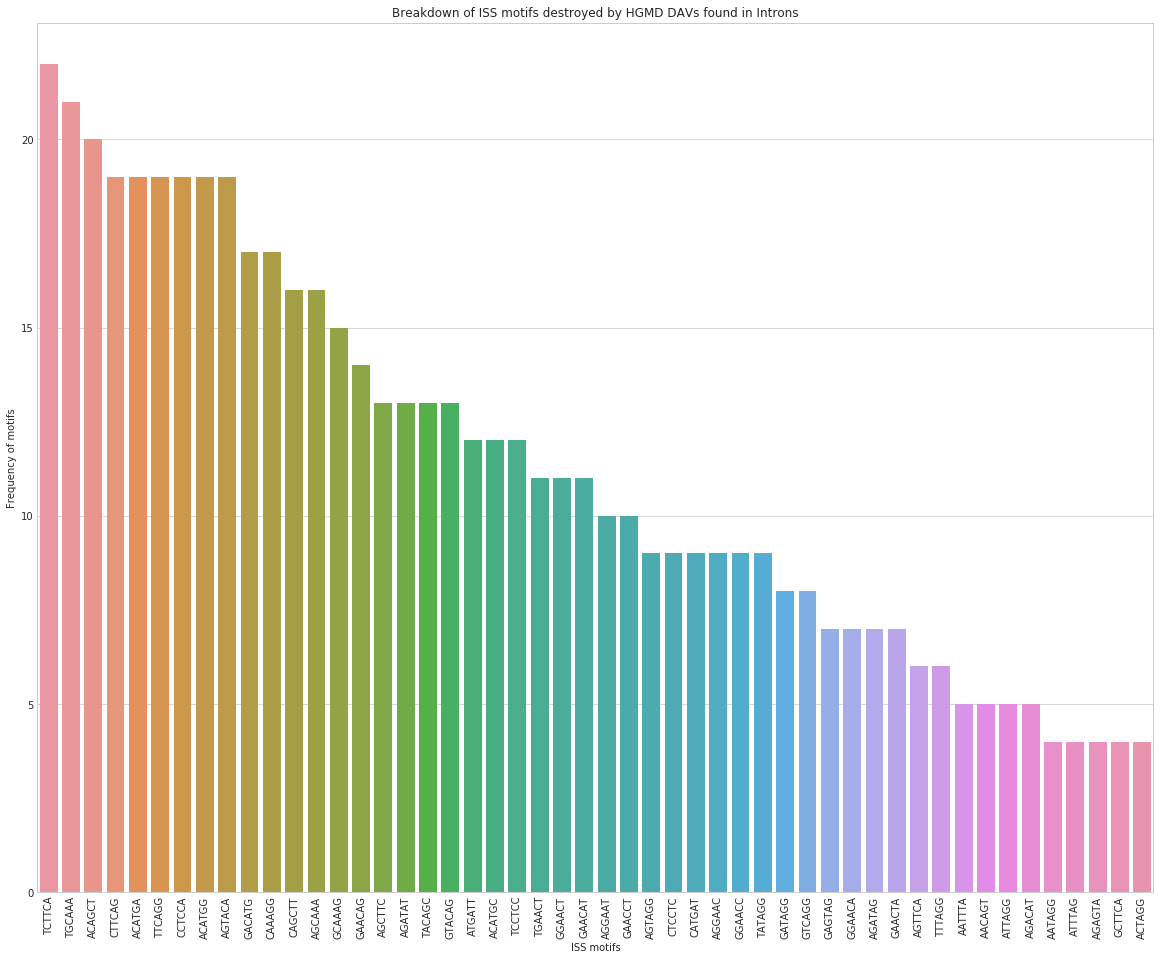

In [72]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_destroyed_Count_df_JustISSs = ISREs_destroyed_counts_df[ISREs_destroyed_counts_df["ISREmotifs"].isin(ISS_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_destroyed_Count_df_JustISSs)
plt.xlabel("ISS motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [73]:
# Look at the top 10 motifs represented
ISREs_destroyed_Count_df_JustISSs.head(n=10)

,ISREmotifs,Numbers
19,TCTTCA,22
21,TGCAAA,21
26,ACAGCT,20
28,CTTCAG,19
30,ACATGA,19
31,TTCAGG,19
32,CCTCCA,19
33,ACATGG,19
34,AGTACA,19
38,GACATG,17


We need to get normalize the counts to ISS motif counts found in introns

In [74]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_destroyed_Count_df_JustISSs_sorted = ISREs_destroyed_Count_df_JustISSs.sort_values(["ISREmotifs"])
print ISREs_destroyed_Count_df_JustISSs_sorted.shape
ISREs_destroyed_Count_df_JustISSs_sorted["Numbers"] = ISREs_destroyed_Count_df_JustISSs_sorted["Numbers"].astype(float)
ISREs_destroyed_Count_df_JustISSs_sorted.head()

(50, 2)


,ISREmotifs,Numbers
115,AACAGT,5.0
122,AATAGG,4.0
110,AATTTA,5.0
26,ACAGCT,20.0
30,ACATGA,19.0


In [75]:
# Add a new column that is the normalized counts
ISREs_destroyed_Count_df_JustISSs_sorted["Normalized_Count"] = (10**8)*ISREs_destroyed_Count_df_JustISSs_sorted["Numbers"].values/(sum(ISREs_destroyed_Count_df_JustISSs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISSs_sorted["Numbers"].values)
print ISREs_destroyed_Count_df_JustISSs_sorted.shape
ISREs_destroyed_Count_df_JustISSs_sorted.head()

(50, 3)


,ISREmotifs,Numbers,Normalized_Count
115,AACAGT,5.0,4.488275
122,AATAGG,4.0,4.670490
110,AATTTA,5.0,2.031093
26,ACAGCT,20.0,19.224389
30,ACATGA,19.0,18.454822


In [76]:
# Re-sort by Normalized Count
ISREs_destroyed_Count_df_JustISSs_sorted_ResortByNormalizedCount = ISREs_destroyed_Count_df_JustISSs_sorted.sort_values(["Normalized_Count"],ascending=False)

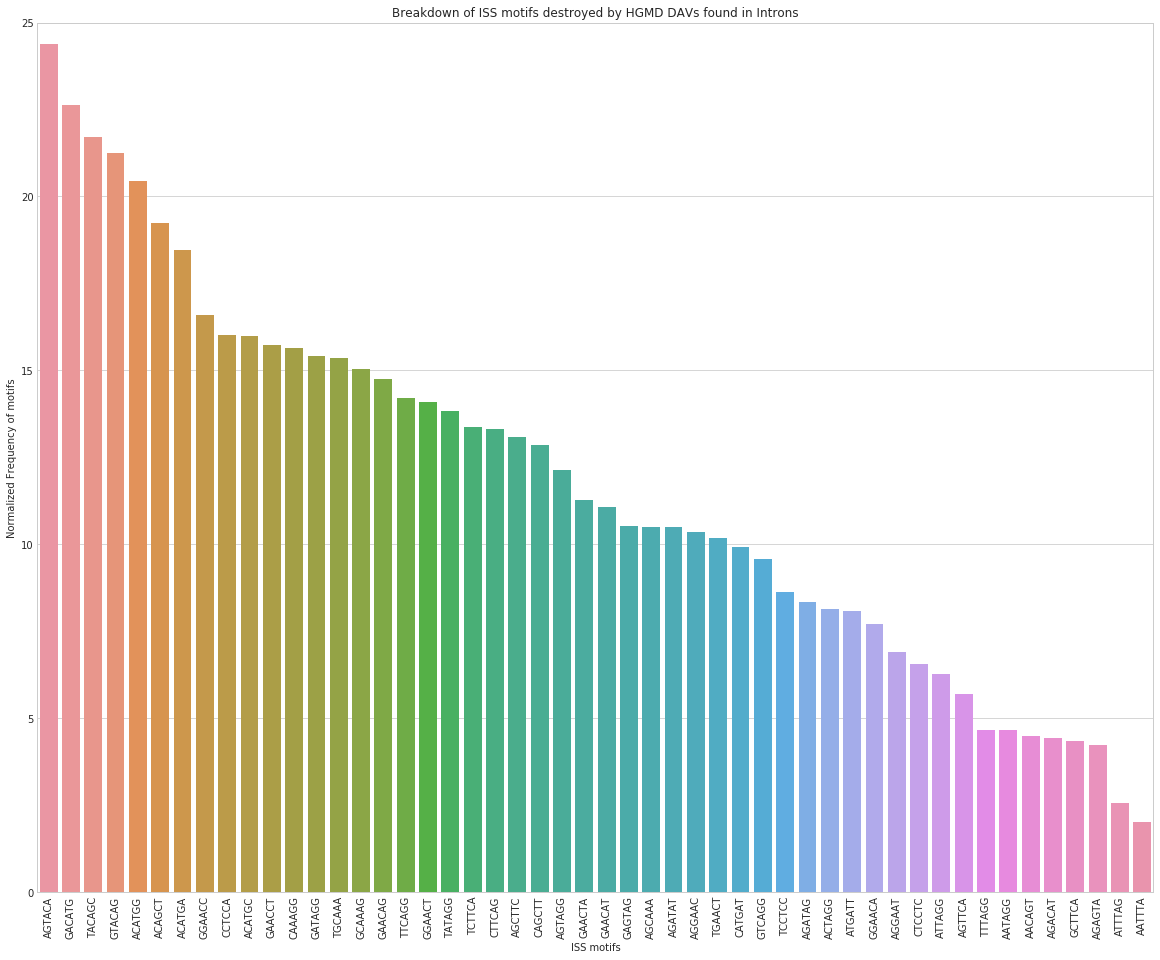

In [79]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_destroyed_Count_df_JustISSs_sorted_ResortByNormalizedCount)
plt.ylim([0,25])
plt.xlabel("ISS motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs destroyed by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [80]:
# Take a look at the top 10
ISREs_destroyed_Count_df_JustISSs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
34,AGTACA,19.0,24.375428
38,GACATG,17.0,22.643536
61,TACAGC,13.0,21.718621
62,GTACAG,13.0,21.239168
33,ACATGG,19.0,20.443536
26,ACAGCT,20.0,19.224389
30,ACATGA,19.0,18.454822
89,GGAACC,9.0,16.600162
32,CCTCCA,19.0,16.016905
66,ACATGC,12.0,16.004315


In [81]:
# Write the ISSs destroyed by DAVs into a file
ISREs_destroyed_Count_df_JustISSs_sorted_ResortByNormalizedCount.to_csv("../temp/ISSs_destroyed_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)

### Investigate enrichment of ISRE motifs that are flanked by DAVs

In [119]:
# These are ISREs 100bp flanked by DAVs 
ISREs_flankedByDAVs = pd.read_csv("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_Flanking_100bpISREs.txt",sep="\t",header=None)
ISREs_flankedByDAVs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,5907098,5907204,ACAGCT,-,chr1,5907193,5907194,CM077307,-,G,A,DM
1,chr1,5909096,5909202,GGTAAG,-,chr1,5909192,5909193,CM051572,-,G,A,DM
2,chr1,5909099,5909205,AGGGGT,-,chr1,5909192,5909193,CM051572,-,G,A,DM
3,chr1,5909166,5909272,TCCTCC,-,chr1,5909192,5909193,CM051572,-,G,A,DM
4,chr1,5909098,5909204,GGGGTA,-,chr1,5909192,5909193,CM051572,-,G,A,DM


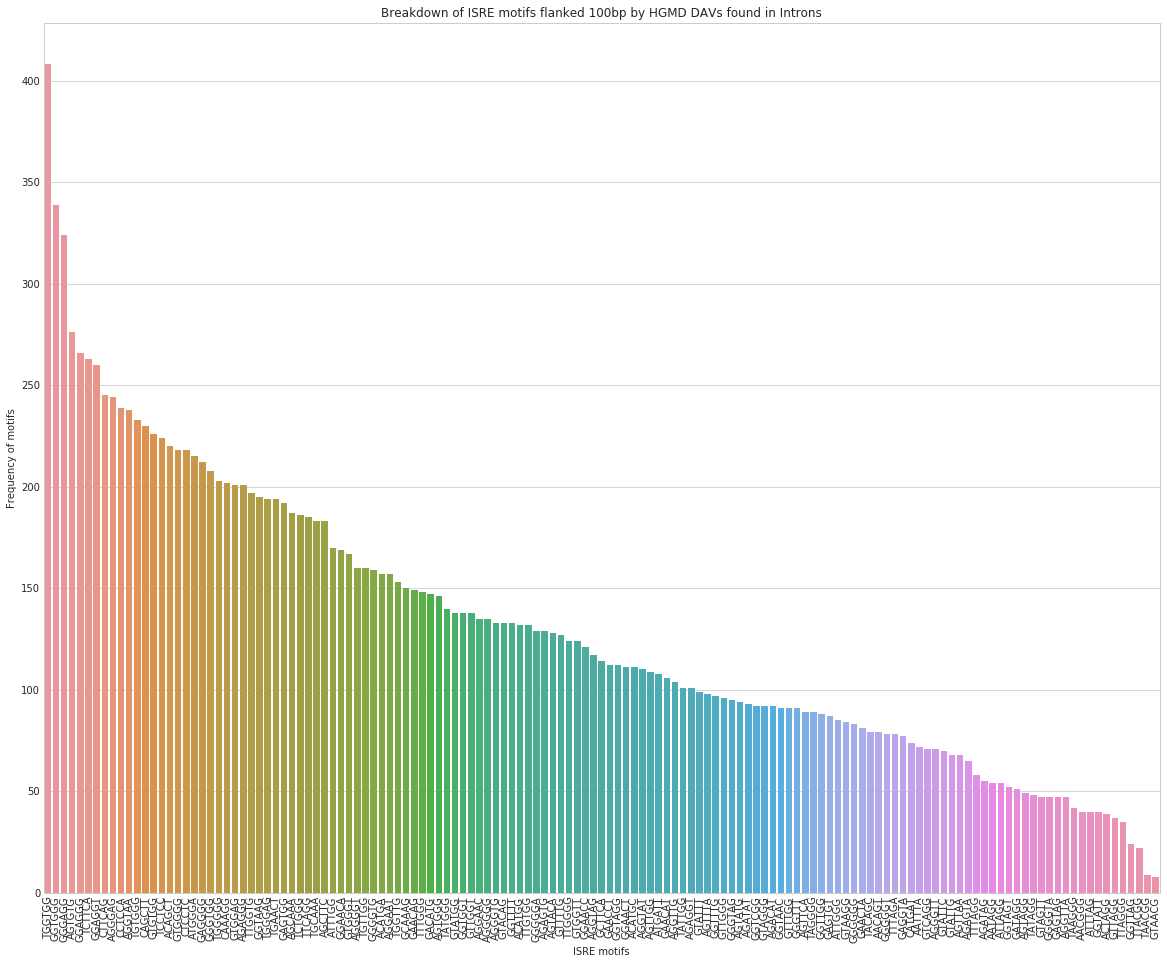

In [120]:
# Look for overrepresented ISREs in those flanked by DAVs
ISREs_flanked_Count = ISREs_flankedByDAVs[3].value_counts()
ISREs_flanked_counts_df = pd.DataFrame({"Numbers":ISREs_flanked_Count.values,"ISREmotifs":ISREs_flanked_Count.index.values},columns=["ISREmotifs","Numbers"])
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_flanked_counts_df)
plt.xlabel("ISRE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs flanked 100bp by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [121]:
# Look at the top 10 motifs represented
ISREs_flanked_counts_df.head(n=10)

,ISREmotifs,Numbers
0,TGGTGG,408
1,GGTGGG,339
2,GGGAGG,324
3,AGTGTG,276
4,GGAGGG,266
5,TCTTCA,263
6,GGAGGT,260
7,CTTCAG,245
8,AGGGAG,244
9,CCTCCA,239


We need to get normalize the counts to ISRE motif counts found in introns

In [122]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_flanked_counts_df_sorted = ISREs_flanked_counts_df.sort_values(["ISREmotifs"])
print ISREs_flanked_counts_df_sorted.shape
ISREs_flanked_counts_df_sorted.head()

(137, 2)


,ISREmotifs,Numbers
102,AACAGT,79
127,AACGGG,40
116,AATAGG,54
107,AATTTA,72
15,ACAGCT,220


In [123]:
# Add a new column that is the normalized counts
ISREs_flanked_counts_df_sorted["Normalized_Count"] = (10**8)*ISREs_flanked_counts_df_sorted["Numbers"]/(sum(ISREs_flanked_counts_df_sorted["Numbers"])*ISREs_inIntron_Count_df_sorted["Numbers"])
print ISREs_flanked_counts_df_sorted.shape
ISREs_flanked_counts_df_sorted.head()

(137, 3)


,ISREmotifs,Numbers,Normalized_Count
102,AACAGT,79,3.375949
127,AACGGG,40,2.487398
116,AATAGG,54,2.792346
107,AATTTA,72,3.227166
15,ACAGCT,220,4.724427


In [124]:
# Re-sort by Normalized Count
ISREs_flanked_counts_df_sorted_ResortByNormalizedCount = ISREs_flanked_counts_df_sorted.sort_values(["Normalized_Count"],ascending=False)

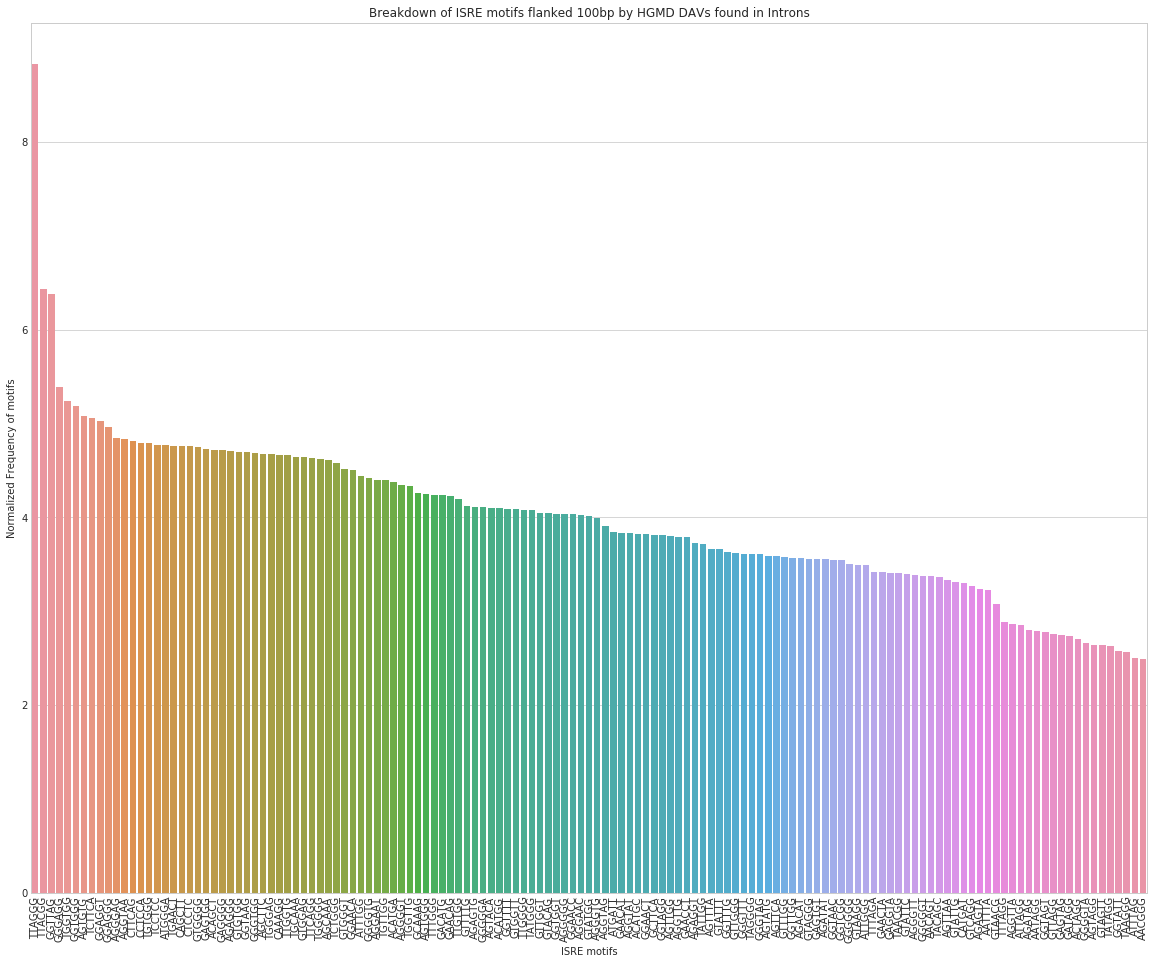

In [125]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_flanked_counts_df_sorted_ResortByNormalizedCount)
plt.xlabel("ISRE motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs flanked 100bp by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [126]:
# Take a look at the top 10
ISREs_flanked_counts_df_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
132,TTAGGG,35,8.828152
134,TTACGG,22,6.438926
133,GGTTAG,24,6.379311
2,GGGAGG,324,5.394164
0,TGGTGG,408,5.245673
1,GGTGGG,339,5.188829
3,AGTGTG,276,5.077566
5,TCTTCA,263,5.055615
6,GGAGGT,260,5.030647
4,GGAGGG,266,4.962600


### Investigate enrichment of ISE motifs that are flanked by DAVs

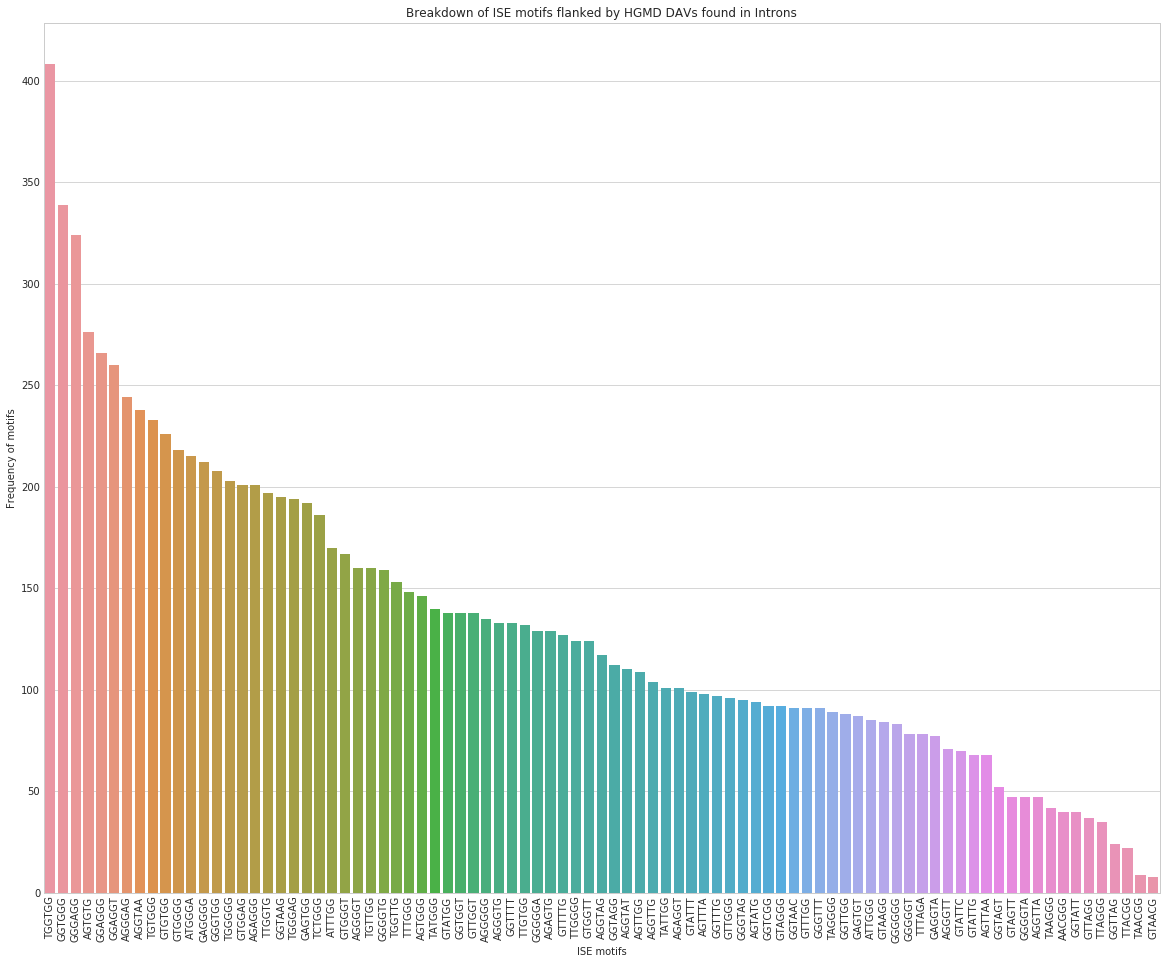

In [127]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_flanked_Count_df_JustISEs = ISREs_flanked_counts_df[ISREs_flanked_counts_df["ISREmotifs"].isin(ISE_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_flanked_Count_df_JustISEs)
plt.xlabel("ISE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs flanked by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [128]:
# Look at the top 10 motifs represented
ISREs_flanked_Count_df_JustISEs.head(n=10)

,ISREmotifs,Numbers
0,TGGTGG,408
1,GGTGGG,339
2,GGGAGG,324
3,AGTGTG,276
4,GGAGGG,266
6,GGAGGT,260
8,AGGGAG,244
10,AGGTAA,238
11,TGTGGG,233
13,GTGTGG,226


We need to get normalize the counts to ISE motif counts found in introns

In [129]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_flanked_Count_df_JustISEs_sorted = ISREs_flanked_Count_df_JustISEs.sort_values(["ISREmotifs"])
print ISREs_flanked_Count_df_JustISEs_sorted.shape
ISREs_flanked_Count_df_JustISEs_sorted["Numbers"] = ISREs_flanked_Count_df_JustISEs_sorted["Numbers"].astype(float)
ISREs_flanked_Count_df_JustISEs_sorted.head()

(87, 2)


,ISREmotifs,Numbers
127,AACGGG,40.0
24,AGAGGG,201.0
79,AGAGGT,101.0
61,AGAGTG,129.0
8,AGGGAG,244.0


In [130]:
# Add a new column that is the normalized counts
ISREs_flanked_Count_df_JustISEs_sorted["Normalized_Count"] = (10**8)*ISREs_flanked_Count_df_JustISEs_sorted["Numbers"].values/(sum(ISREs_flanked_Count_df_JustISEs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISEs_sorted["Numbers"].values)
print ISREs_flanked_Count_df_JustISEs_sorted.shape
ISREs_flanked_Count_df_JustISEs_sorted.head()

(87, 3)


,ISREmotifs,Numbers,Normalized_Count
127,AACGGG,40.0,16.467157
24,AGAGGG,201.0,7.649278
79,AGAGGT,101.0,4.671713
61,AGAGTG,129.0,5.757394
8,AGGGAG,244.0,7.419537


In [131]:
# Re-sort by Normalized Count
ISREs_flanked_Count_df_JustISEs_sorted_ResortByNormalizedCount = ISREs_flanked_Count_df_JustISEs_sorted.sort_values(["Normalized_Count"],ascending=False)

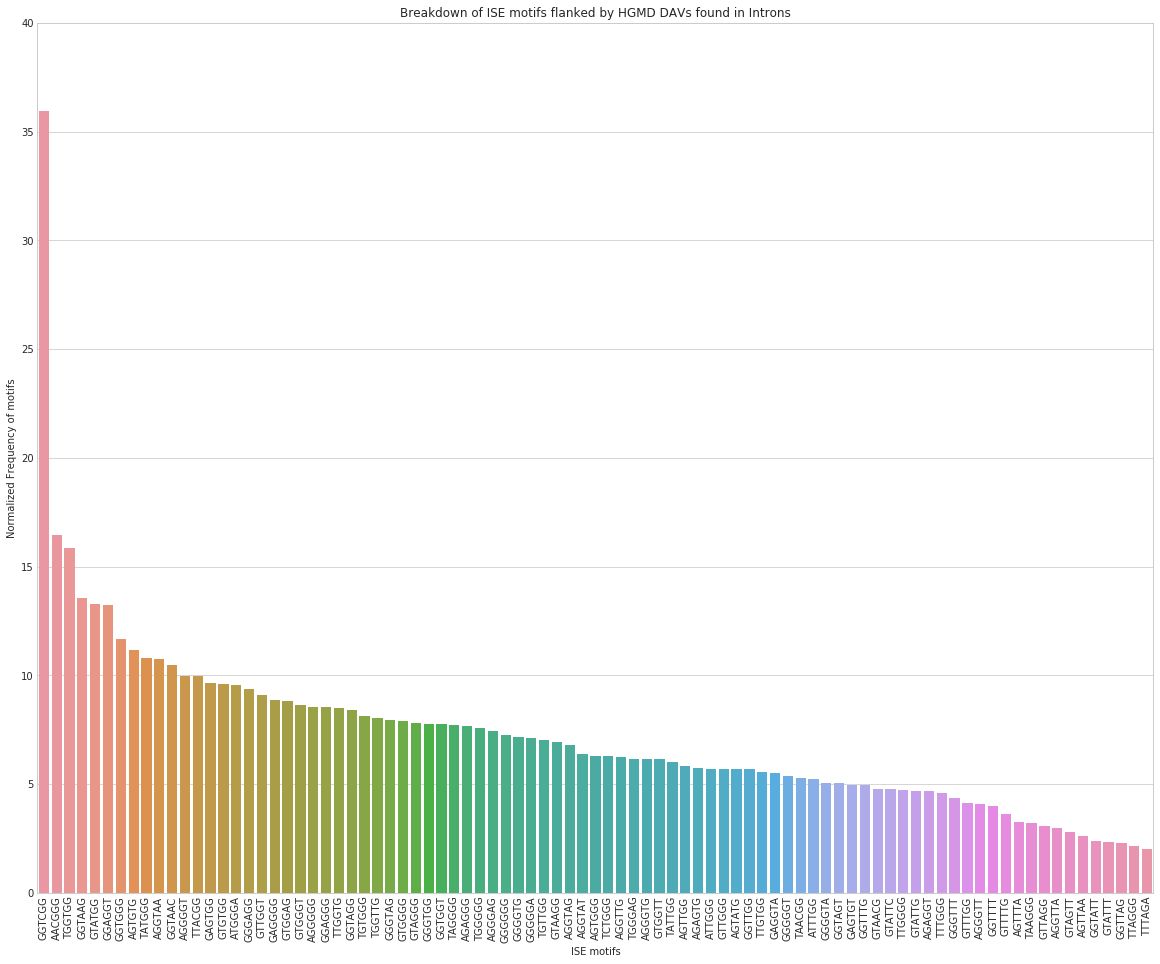

In [133]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_flanked_Count_df_JustISEs_sorted_ResortByNormalizedCount)
plt.ylim([0,40])
plt.xlabel("ISE motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISE motifs flanked by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [134]:
# Take a look at the top 10
ISREs_flanked_Count_df_JustISEs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
87,GGTCGG,92.0,35.940634
127,AACGGG,40.0,16.467157
0,TGGTGG,408.0,15.845684
26,GGTAAG,195.0,13.536909
50,GTATGG,138.0,13.291085
6,GGAGGT,260.0,13.251049
1,GGTGGG,339.0,11.679307
3,AGTGTG,276.0,11.176122
49,TATGGG,140.0,10.796330
10,AGGTAA,238.0,10.736751


In [135]:
# Write the ISEs flanked by DAVs into a file
ISREs_flanked_Count_df_JustISEs_sorted_ResortByNormalizedCount.to_csv("../temp/ISEs_flanked_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)

### Investigate enrichment of ISS motifs that are flanked by DAVs

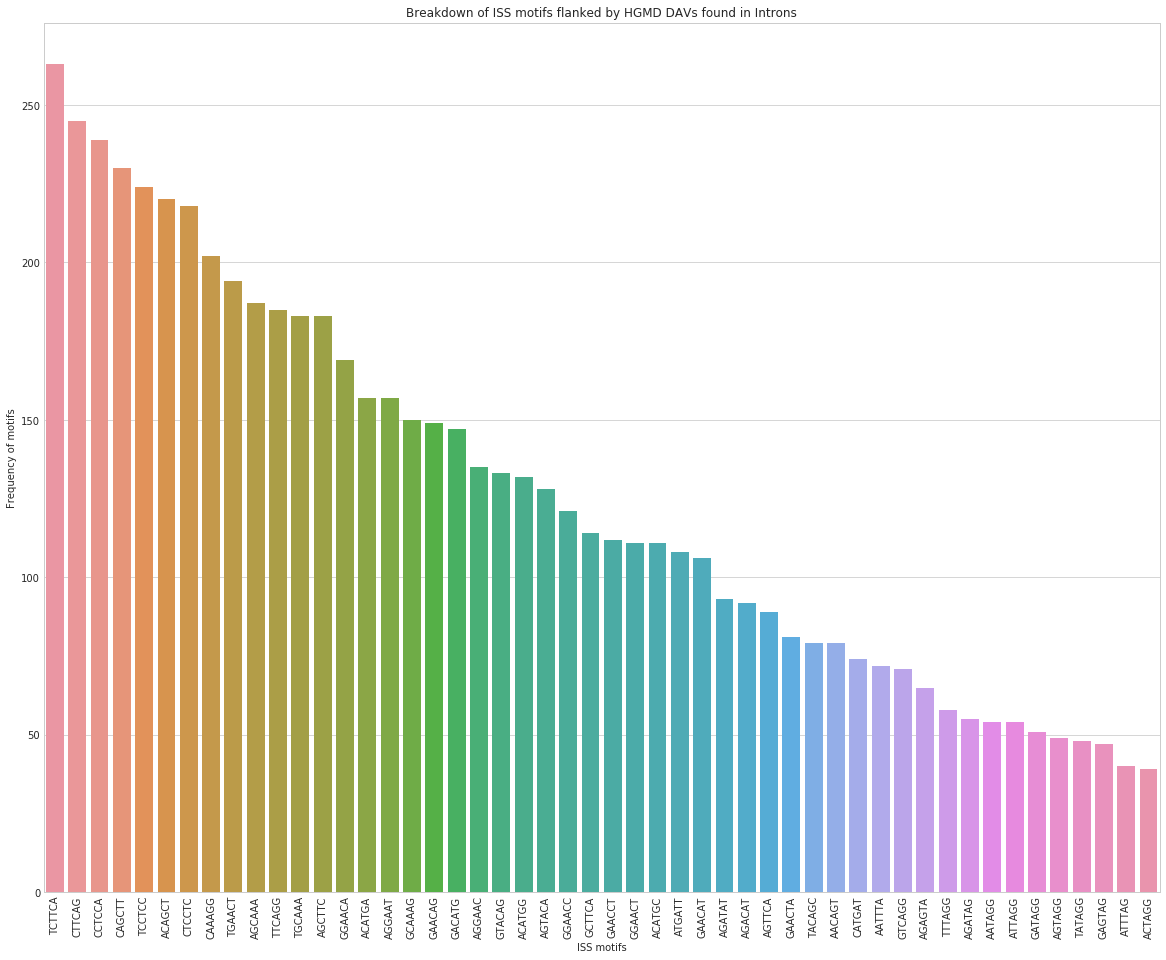

In [136]:
# Look for overrepresented ISREs that are created by DAVs
ISREs_flanked_Count_df_JustISSs = ISREs_flanked_counts_df[ISREs_flanked_counts_df["ISREmotifs"].isin(ISS_motifs[0])]
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_flanked_Count_df_JustISSs)
plt.xlabel("ISS motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs flanked by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [137]:
# Look at the top 10 motifs represented
ISREs_flanked_Count_df_JustISSs.head(n=10)

,ISREmotifs,Numbers
5,TCTTCA,263
7,CTTCAG,245
9,CCTCCA,239
12,CAGCTT,230
14,TCCTCC,224
15,ACAGCT,220
17,CTCCTC,218
22,CAAAGG,202
28,TGAACT,194
30,AGCAAA,187


We need to get normalize the counts to ISS motif counts found in introns

In [138]:
# Let's sort the counts by motif like the counts for ISRE motifs found in Introns
ISREs_flanked_Count_df_JustISSs_sorted = ISREs_flanked_Count_df_JustISSs.sort_values(["ISREmotifs"])
print ISREs_flanked_Count_df_JustISSs_sorted.shape
ISREs_flanked_Count_df_JustISSs_sorted["Numbers"] = ISREs_flanked_Count_df_JustISSs_sorted["Numbers"].astype(float)
ISREs_flanked_Count_df_JustISSs_sorted.head()

(50, 2)


,ISREmotifs,Numbers
102,AACAGT,79.0
116,AATAGG,54.0
107,AATTTA,72.0
15,ACAGCT,220.0
41,ACATGA,157.0


In [139]:
# Add a new column that is the normalized counts
ISREs_flanked_Count_df_JustISSs_sorted["Normalized_Count"] = (10**8)*ISREs_flanked_Count_df_JustISSs_sorted["Numbers"].values/(sum(ISREs_flanked_Count_df_JustISSs_sorted["Numbers"].values)*ISREs_inIntron_Count_df_JustISSs_sorted["Numbers"].values)
print ISREs_flanked_Count_df_JustISSs_sorted.shape
ISREs_flanked_Count_df_JustISSs_sorted.head()

(50, 3)


,ISREmotifs,Numbers,Normalized_Count
102,AACAGT,79.0,6.334286
116,AATAGG,54.0,5.631930
107,AATTTA,72.0,2.612482
15,ACAGCT,220.0,18.888884
41,ACATGA,157.0,13.621251


In [140]:
# Re-sort by Normalized Count
ISREs_flanked_Count_df_JustISSs_sorted_ResortByNormalizedCount = ISREs_flanked_Count_df_JustISSs_sorted.sort_values(["Normalized_Count"],ascending=False)

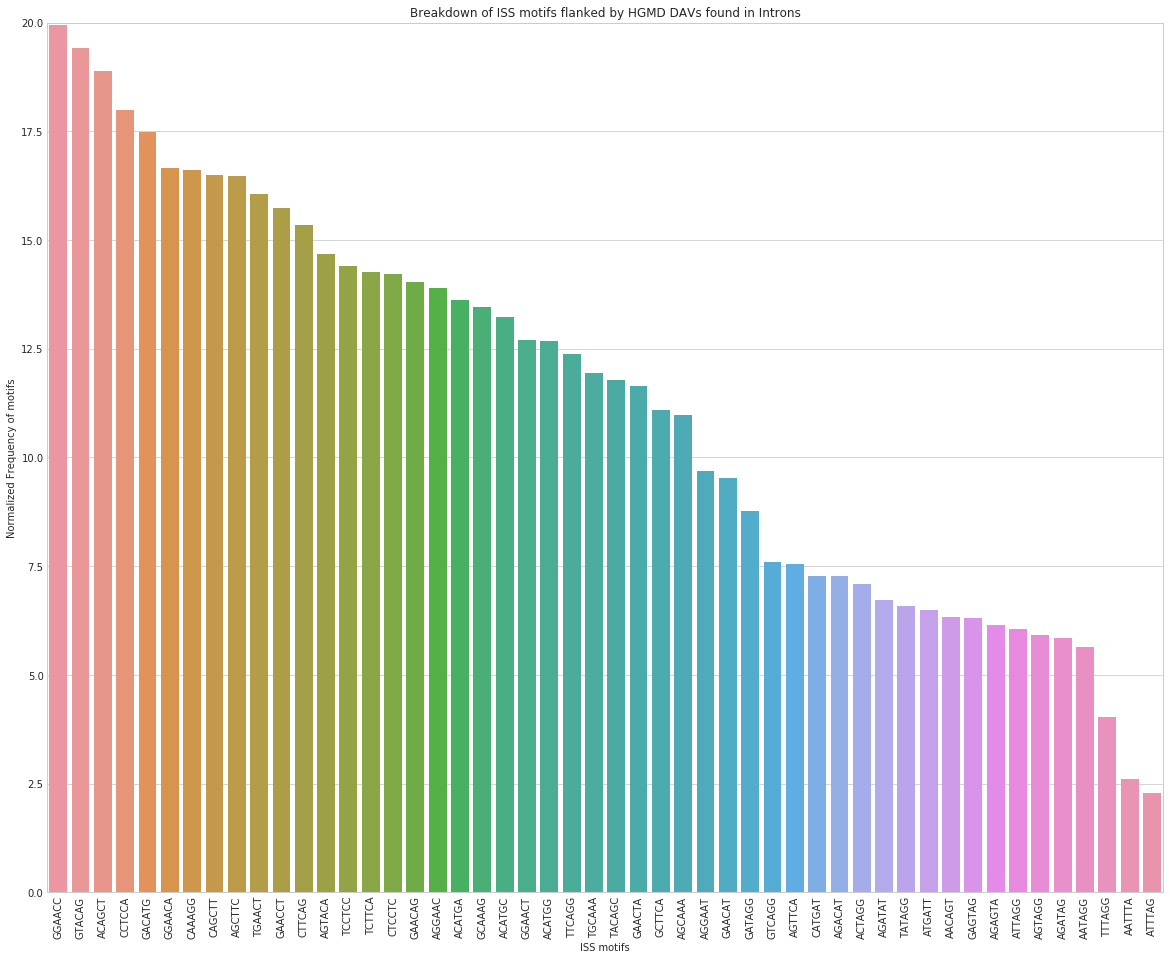

In [143]:
# Plot the frequency distribution now
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Normalized_Count",data=ISREs_flanked_Count_df_JustISSs_sorted_ResortByNormalizedCount)
plt.ylim([0,20])
plt.xlabel("ISS motifs")
plt.ylabel("Normalized Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISS motifs flanked by "+whichDataSet+" DAVs found in Introns")
plt.show()

In [144]:
# Take a look at the top 10
ISREs_flanked_Count_df_JustISSs_sorted_ResortByNormalizedCount.head(n=10)

,ISREmotifs,Numbers,Normalized_Count
66,GGAACC,121.0,19.935002
56,GTACAG,133.0,19.409166
15,ACAGCT,220.0,18.888884
9,CCTCCA,239.0,17.996332
47,GACATG,147.0,17.489353
36,GGAACA,169.0,16.657324
22,CAAAGG,202.0,16.598593
12,CAGCTT,230.0,16.490822
34,AGCTTC,183.0,16.467935
28,TGAACT,194.0,16.059667


In [145]:
# Write the ISSs flanked by DAVs into a file
ISREs_flanked_Count_df_JustISSs_sorted_ResortByNormalizedCount.to_csv("../temp/ISSs_flanked_DAVs_NormalizedCounts.txt",sep="\t",header=False,index=False)